In [1]:
from pathlib import Path

import numpy as np

from fies_utils import estimate_v_rad, correct_spectrum_for_vrad
from plotting_utils import plot_spectral_features, plot_zoom
from spectral_features import get_spectral_features_vrad_correction, SpectralFeature
from spectroscopy.spectrum_loader import SpectrumLoader

In [3]:
DATA_PATH = Path.cwd() / "data"
FITS_PATH = DATA_PATH / "fits"
OBSERVATIONS_PATH = DATA_PATH / "observations.csv"
CORRECTED_FILE = DATA_PATH / "out" / "2_vrad_corrected_spectra.npz"
spectrum_loader = SpectrumLoader(fits_path=FITS_PATH, observations_path=OBSERVATIONS_PATH)

# Load observations and list available targets 

In [4]:
def print_targets():
    print("Available Spectra:")
    for target_name in spectrum_loader.target_list:
        print(f"\t* {target_name}: {spectrum_loader.get_available_spectra_count(target_name)}")

print_targets()

Available Spectra:
	* BECet: 6
	* EXCet: 3
	* HNPeg: 3
	* V383Lac: 3
	* V453And: 3
	* V774Tau: 3
	* V834Tau: 3
	* V889Her: 3


# Estimate $V_{rad}$ for all available targets

In [5]:
def flatten_concatenation(lists: list[list]):
    flat_list = []
    for l in lists:
        flat_list += l
    return flat_list

def estimate_all_targets_vrad(targets: list[str], spectral_features: list[SpectralFeature]):
    print("Loading target spectra...")
    all_spectra = [spectrum_loader.get_spectra(t) for t in targets]
    all_spectra = flatten_concatenation(all_spectra)
    print(f"Loaded {len(all_spectra)} spectra")
    
    print("Correcting spectra...")
    estimations = {}
    for i, spectrum in enumerate(all_spectra):
        if spectrum.target_name not in estimations:
            estimations[spectrum.target_name] = {}
        estimations[spectrum.target_name][spectrum.id] = estimate_v_rad(spectrum.data, spectral_features) 
    print("Done")
    return estimations

# Uses default spectral features
def print_estimation_statistics(estimations: dict):
    df = {}
    for target, exposures in estimations.items():
        vrads = np.hstack([v for v in exposures.values()])
        print(f"** {target} **")
        print(f"\t - Mean: {vrads.mean()}")
        print(f"\t - Median: {np.median(vrads)}")
        print(f"\t - Standard Deviation: {vrads.std()}")
        print(f"\t - [Min, Max]: [{vrads.min()}, {vrads.max()}]")
        print()
        df[target] = vrads
    return df

In [6]:
_spectral_features = get_spectral_features_vrad_correction(width=2)
_estimations = estimate_all_targets_vrad(spectrum_loader.target_list, _spectral_features)

Loading target spectra...
Loaded 27 spectra
Correcting spectra...
Done


In [7]:
_vrads = print_estimation_statistics(_estimations)

** BECet **
	 - Mean: -14.161939354149547
	 - Median: -13.990574234601404
	 - Standard Deviation: 0.6034065141401176
	 - [Min, Max]: [-16.19429247770638, -13.352595120702148]

** EXCet **
	 - Mean: -11.863435610948635
	 - Median: -18.27778373813102
	 - Standard Deviation: 18.074410200367925
	 - [Min, Max]: [-20.10622943505729, 40.040889128411216]

** HNPeg **
	 - Mean: -7.038045608515062
	 - Median: -7.0397965052140865
	 - Standard Deviation: 0.2687166823405955
	 - [Min, Max]: [-7.462114820701313, -6.567975841015735]

** V383Lac **
	 - Mean: 10.961370706977958
	 - Median: 10.991211305681372
	 - Standard Deviation: 0.4359689372507991
	 - [Min, Max]: [9.895822340053606, 11.748416395284652]

** V453And **
	 - Mean: -11.419923568495538
	 - Median: -11.299465319485687
	 - Standard Deviation: 0.4252250629915667
	 - [Min, Max]: [-12.561312821545103, -10.99065022850009]

** V774Tau **
	 - Mean: 1.9910451764777706
	 - Median: 21.008226621802876
	 - Standard Deviation: 27.46063982630807
	 - [Min

$V_{rad}$ can be estimated with enough accuracy for most stars. However, there are some with high variance in estimated values that need a closer look.

# Single Target Investigation
## Correcting ExCet
EXCet estimation for v_rad can be corrected by widening the size of the features:

Loading target spectra...
Loaded 3 spectra
Correcting spectra...
Done
** EXCet **
	 - Mean: -18.663765109122558
	 - Median: -18.84216576554949
	 - Standard Deviation: 0.7407066941226899
	 - [Min, Max]: [-19.57380024920041, -16.507754575661163]


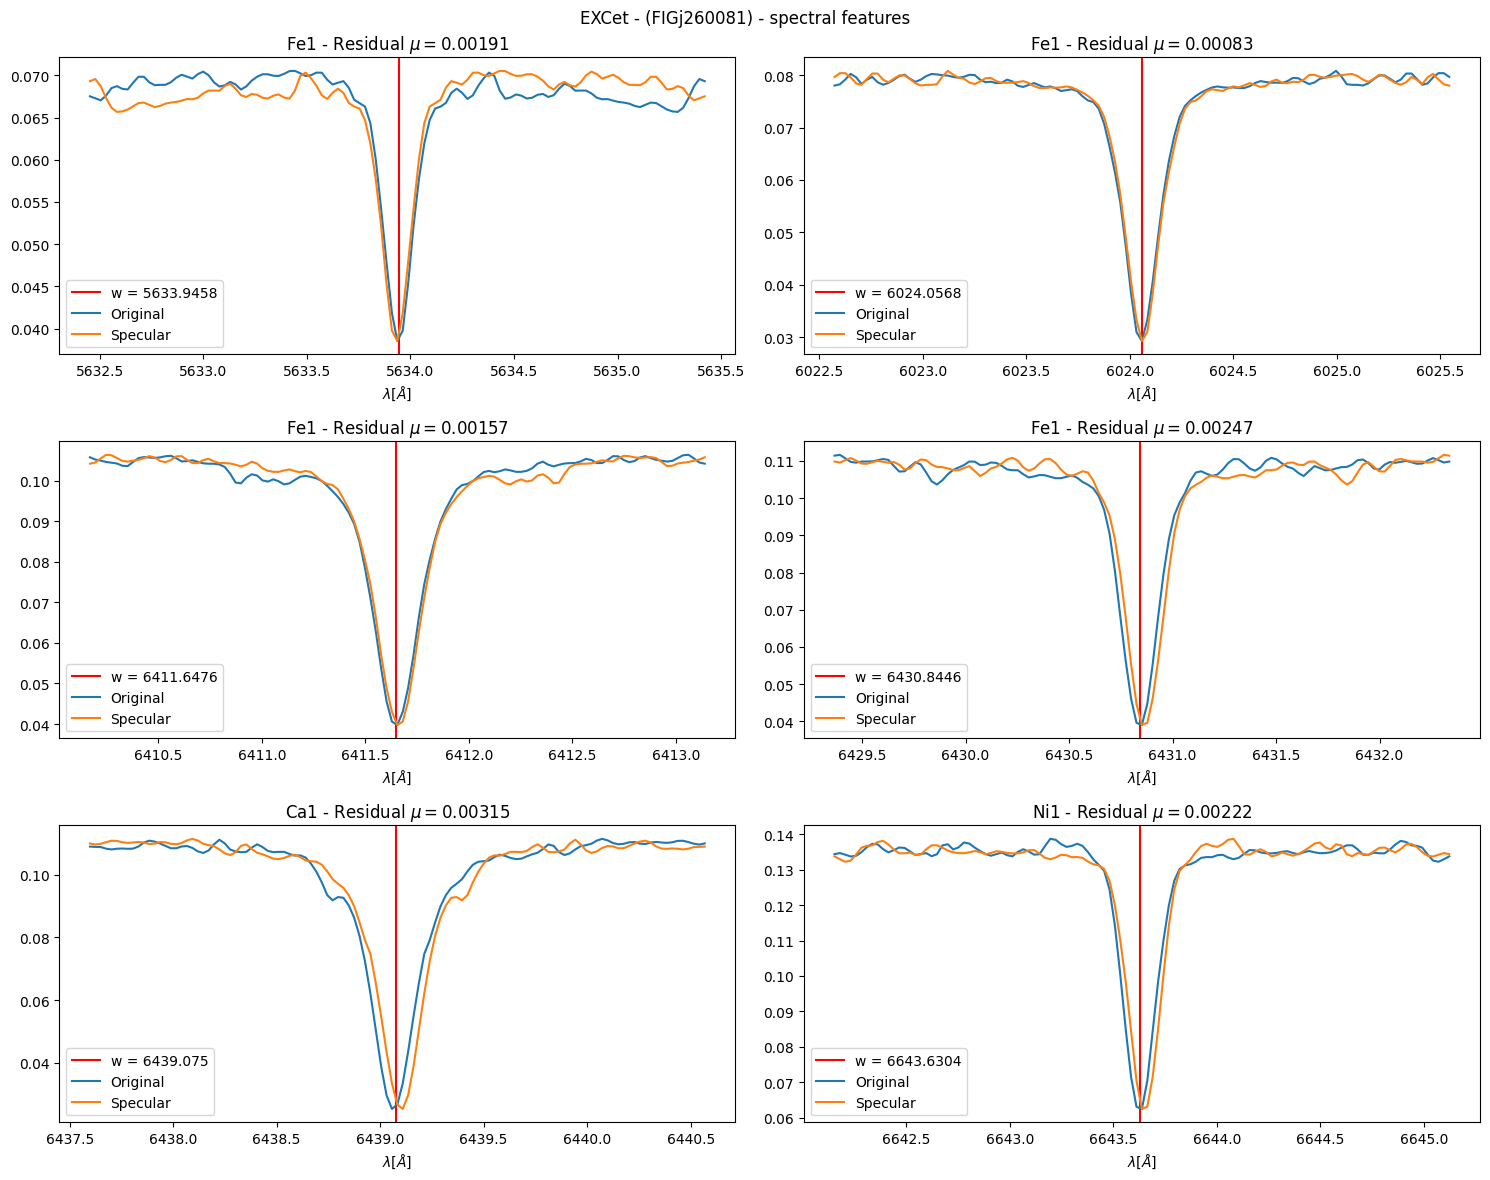

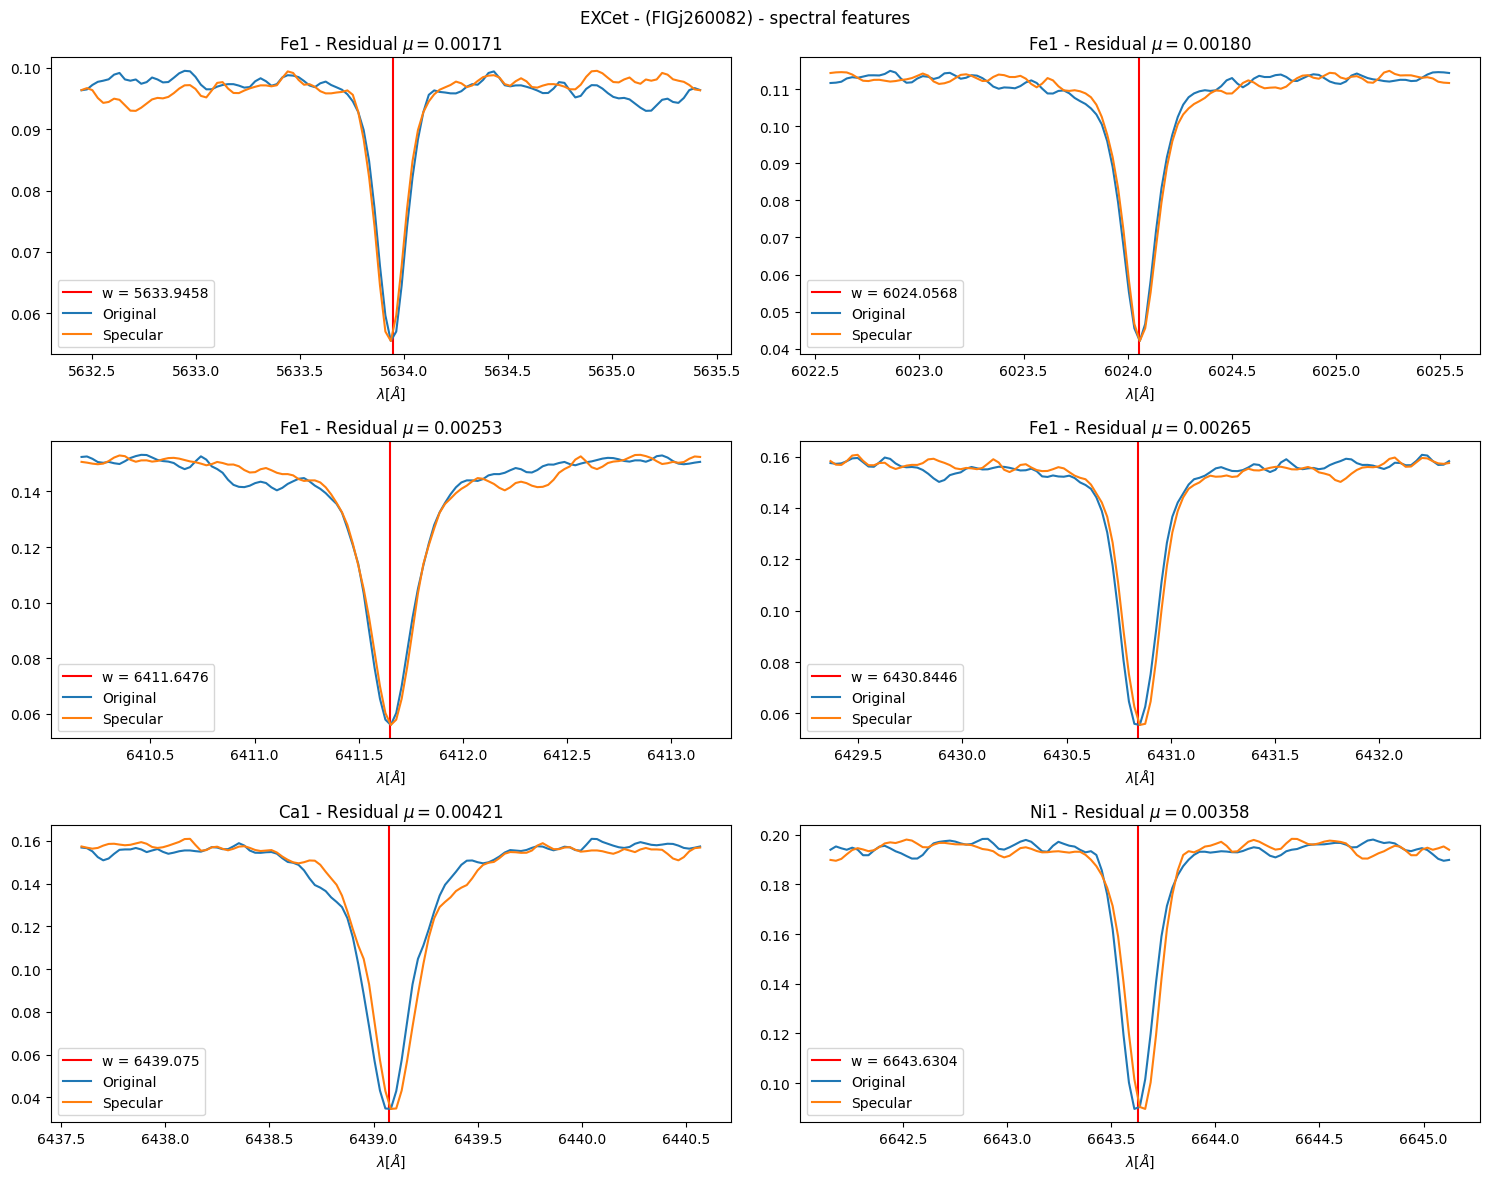

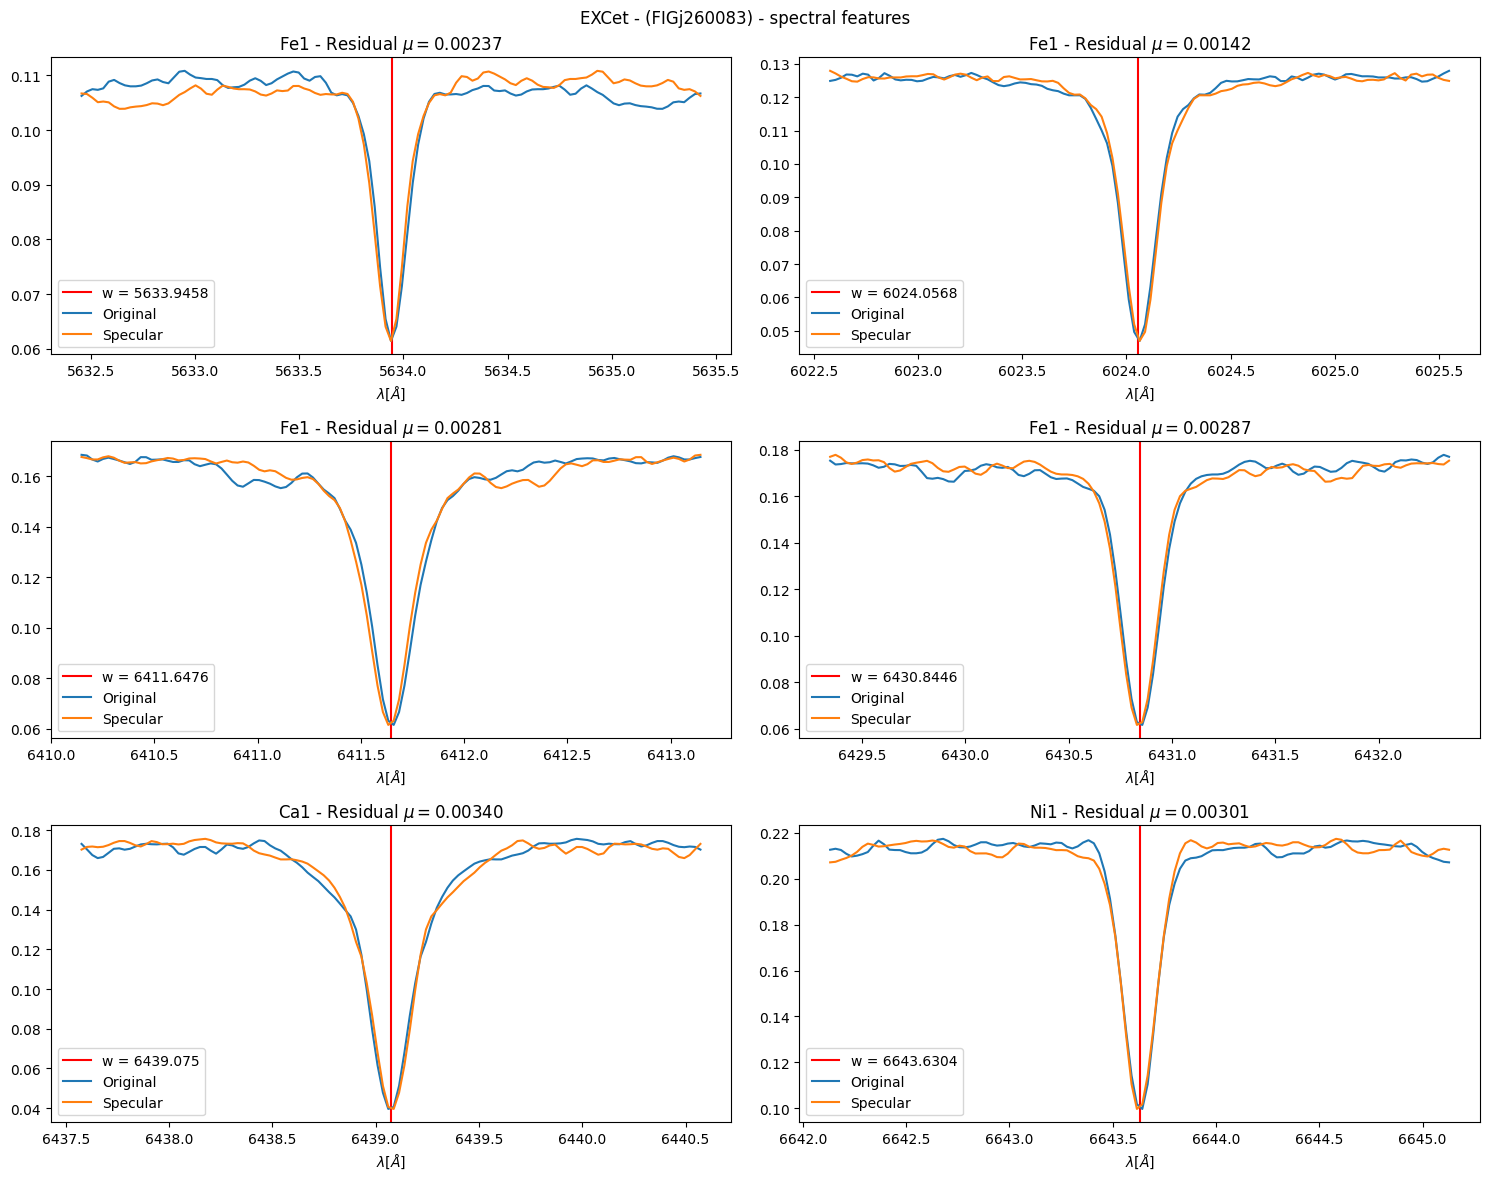

In [8]:
def correct_EXCet():
    target = "EXCet"
    features = get_spectral_features_vrad_correction(width=3)
    estimations = estimate_all_targets_vrad([target], features)
    df = print_estimation_statistics(estimations)
    
    for spectrum in spectrum_loader.get_spectra(target):
        v_rad = np.median(estimate_v_rad(spectrum.data, features))
        spectrum.data = correct_spectrum_for_vrad(spectrum.data, v_rad)
        plot_spectral_features(spectrum, features)
    
    # Apply correction
    _vrads[target] = df[target]
    
correct_EXCet()

## Correcting V774Tau
The features don't give stable results with the default settings. We tune the feature's size so that the algorithm can find a good fit for them.

V774Tau v_rad estimations with default features
V_rad estimations with FIGj260087: [ 21.38006047  21.43911777  20.5010079   20.76218986  20.43278931
 -11.08708743]
V_rad estimations with FIGj260088: [ 20.14781543  21.13967125  20.48831462  24.54872904  21.24063489
 -15.19559193]
V_rad estimations with FIGj260089: [22.49701084 21.16422181 24.4830226  20.72880963 21.50454441 21.18062034]


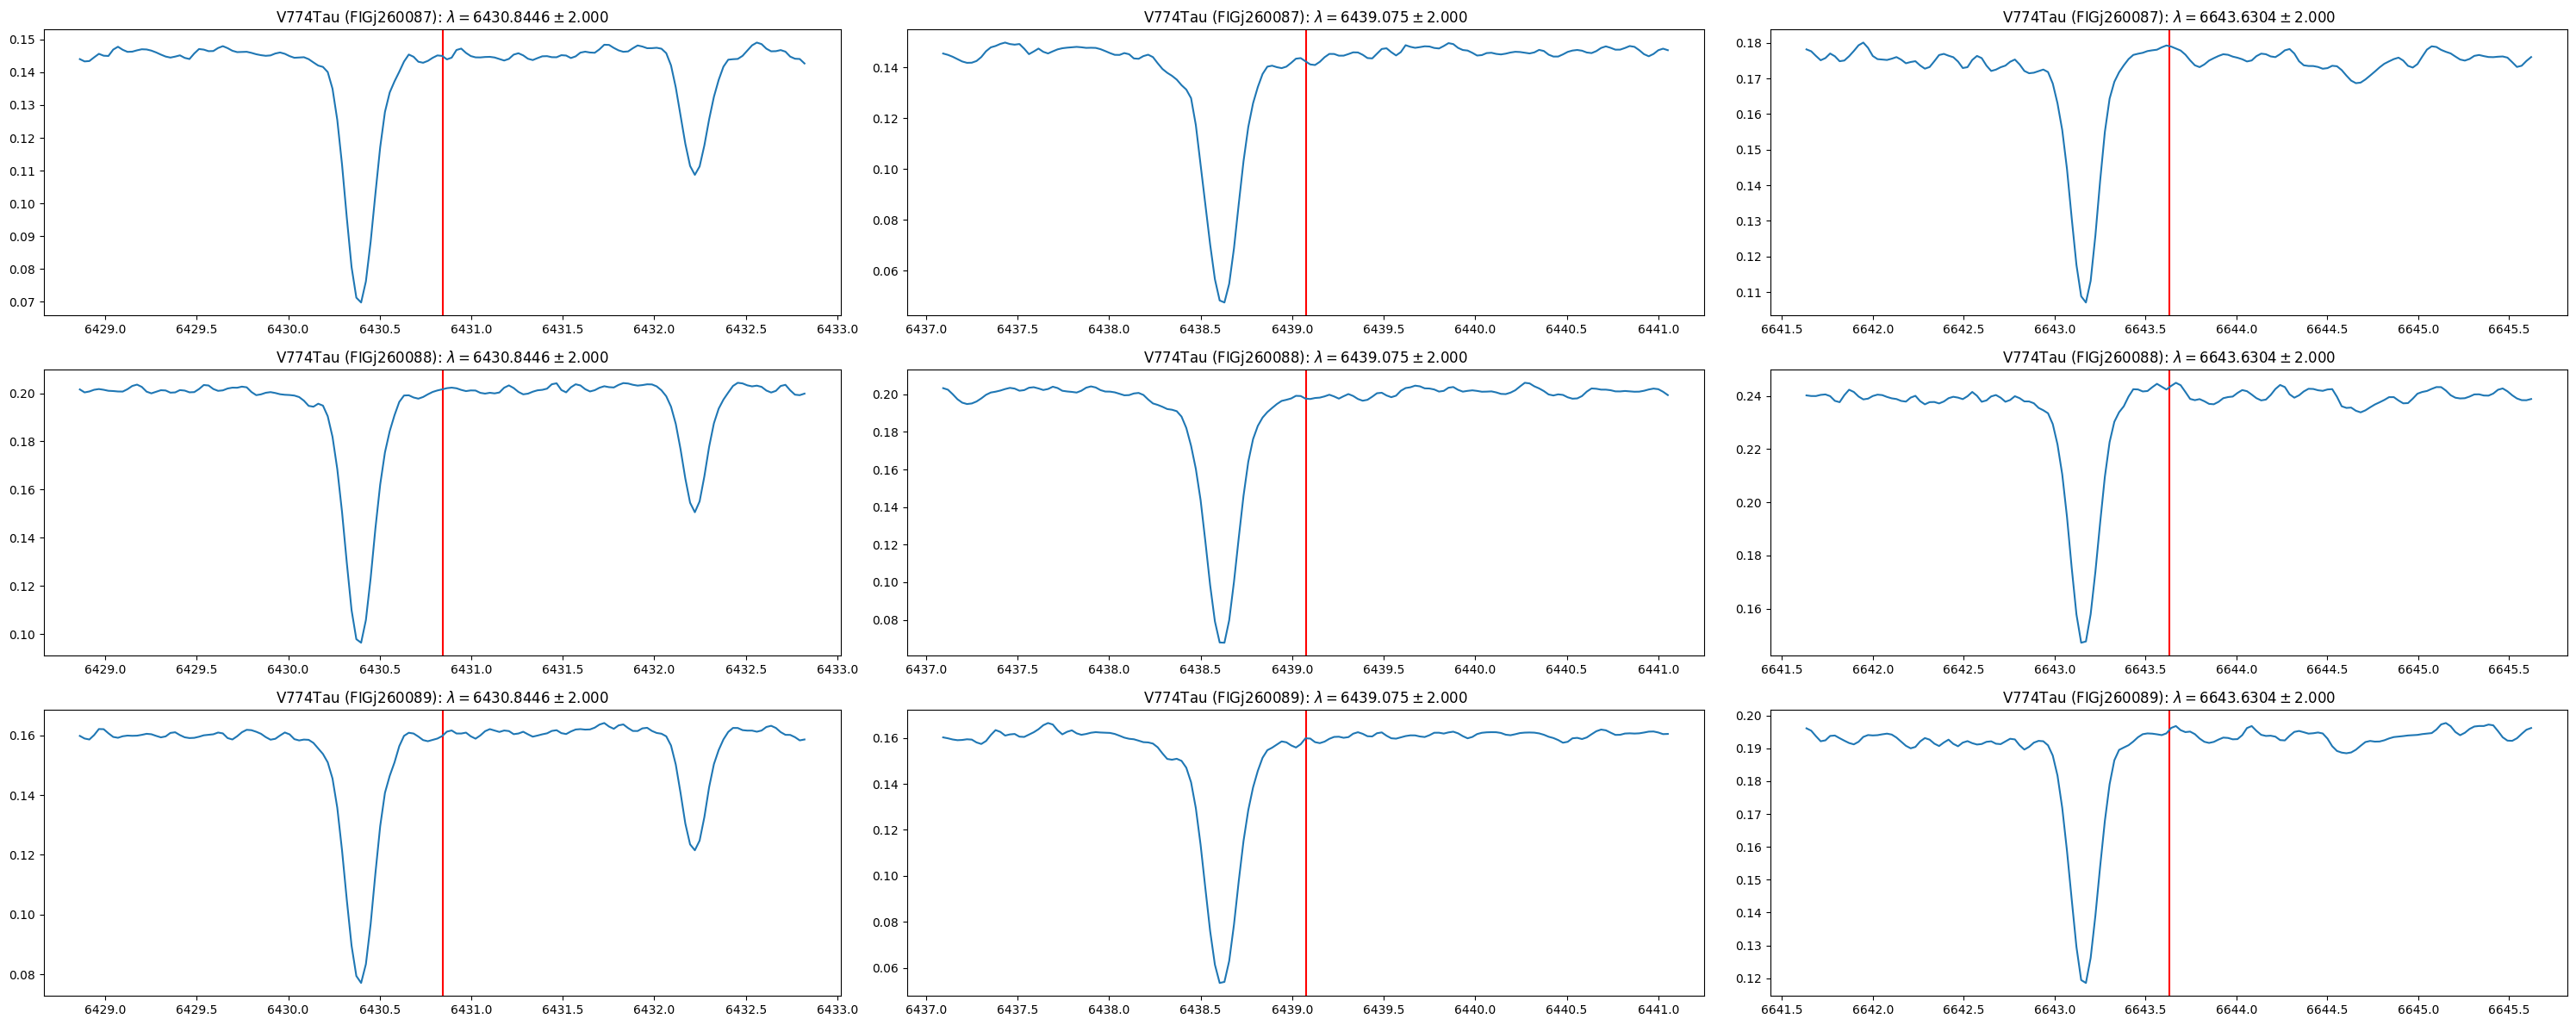

V774Tau v_rad estimations after feature tuning
V_rad estimations with FIGj260087: [21.38006047 21.43911777 21.14206321 21.00382047 21.562707   21.17438808]
V_rad estimations with FIGj260088: [20.14781543 21.13967125 22.03234238 21.17666913 21.55070312 21.2323821 ]
V_rad estimations with FIGj260089: [22.49701084 21.16422181 22.07604211 20.81076251 21.6098487  21.30520946]
Loading target spectra...
Loaded 3 spectra
Correcting spectra...
Done
** V774Tau **
	 - Mean: 21.35804643488387
	 - Median: 21.26879577708655
	 - Standard Deviation: 0.5013131373878335
	 - [Min, Max]: [20.147815431115397, 22.497010839647622]


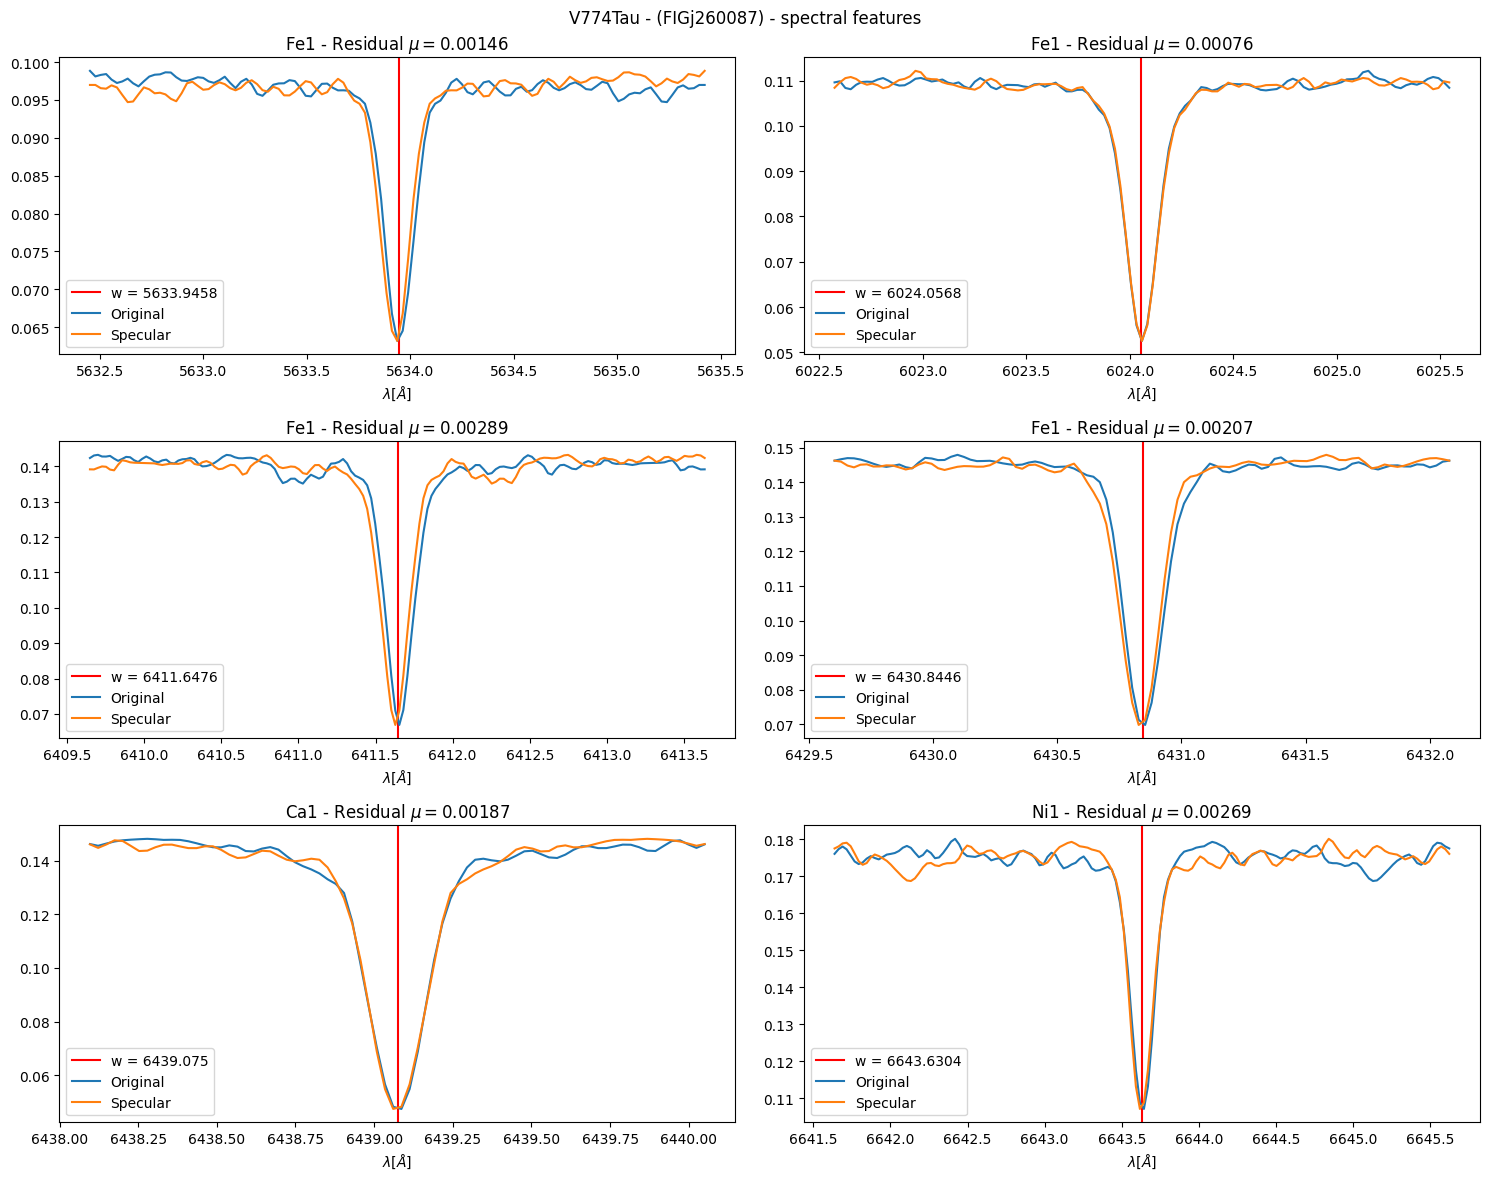

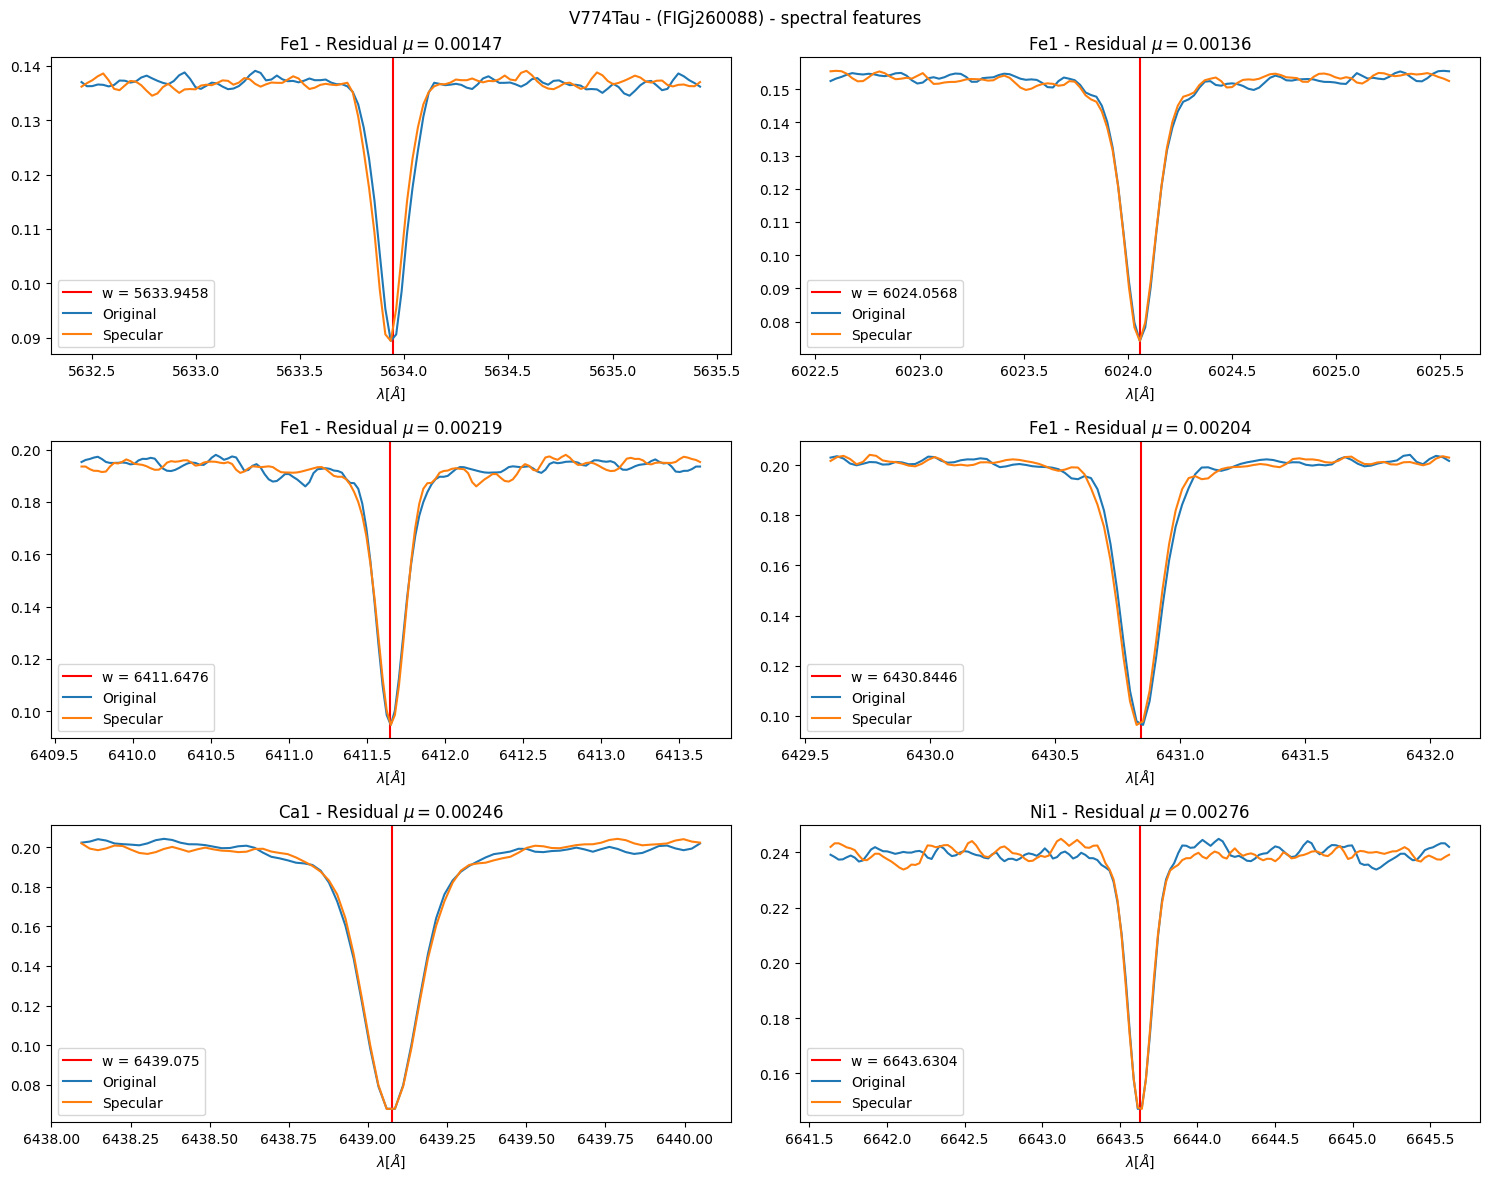

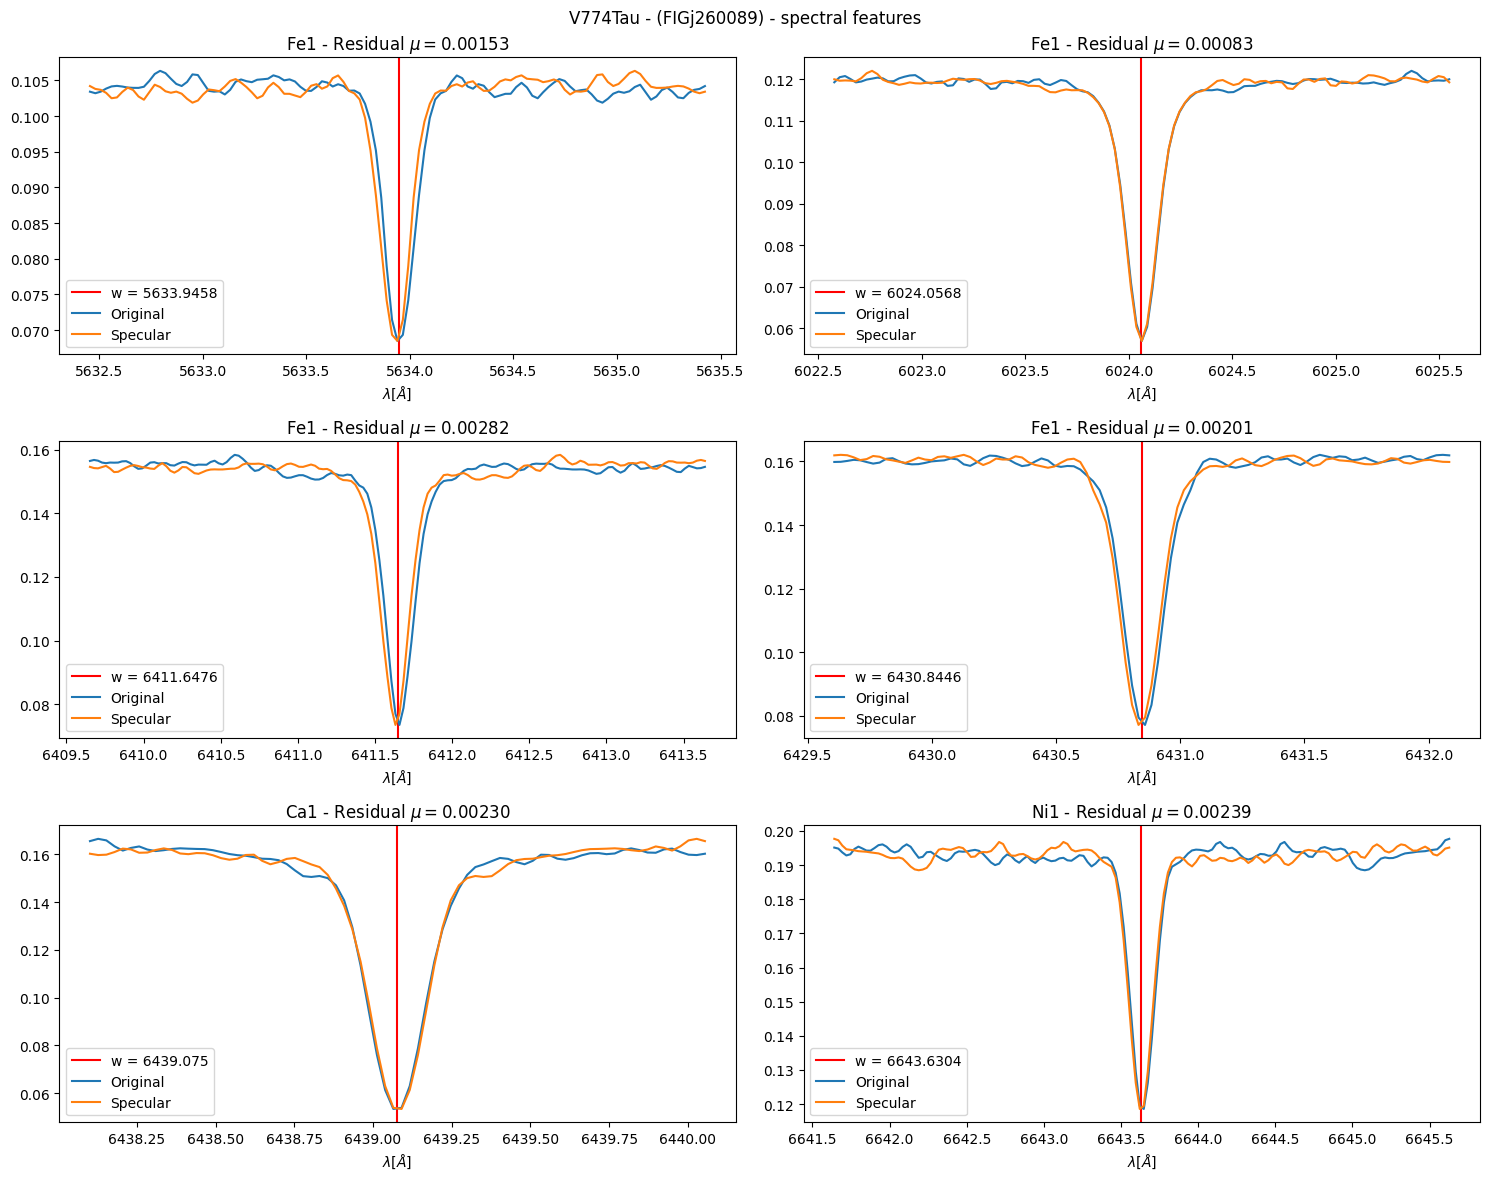

In [9]:
def correct_V774Tau():
    target = "V774Tau"
    features = get_spectral_features_vrad_correction()
    spectra = spectrum_loader.get_spectra(target)
    
    print(f"{target} v_rad estimations with default features")
    for spectrum in spectra:
        estimations = estimate_v_rad(spectrum.data, features)
        print(f"V_rad estimations with {spectrum.id}: {estimations}")
        
    # Plot problematic features
    plot_zoom(spectra, [features[i].w for i in [3, 4, 5]], width=4)
    
    features[5].width = 4
    features[4].width = 2
    features[3].width = 2.5
    features[2].width = 4

    print(f"{target} v_rad estimations after feature tuning")
    for spectrum in spectra:
        estimations = estimate_v_rad(spectrum.data, features)
        print(f"V_rad estimations with {spectrum.id}: {estimations}")

    estimations = estimate_all_targets_vrad(["V774Tau"], features)
    df = print_estimation_statistics(estimations)
    
    for spectrum in spectra:
        v_rad = np.median(estimate_v_rad(spectrum.data, features))
        spectrum.data = correct_spectrum_for_vrad(spectrum.data, v_rad)
        plot_spectral_features(spectrum, features)
    
    # Apply correction
    _vrads[target] = df[target]
    
correct_V774Tau()

## Correcting V889Her
We see that the first feature gives bad estimations. Let's just ignore it.

V889Her v_rad estimations with default features
V_rad estimations with FIGj260063: [-52.96069732   1.61800759   1.13186905   3.02959835   2.52324358
   1.41113808]
V_rad estimations with FIGj260064: [-56.56102241   0.14375479   2.98263312   0.80732669   1.17340393
   1.52340817]
V_rad estimations with FIGj260065: [0.70441029 2.66093919 0.42814256 2.4377297  2.52834205 1.74668448]


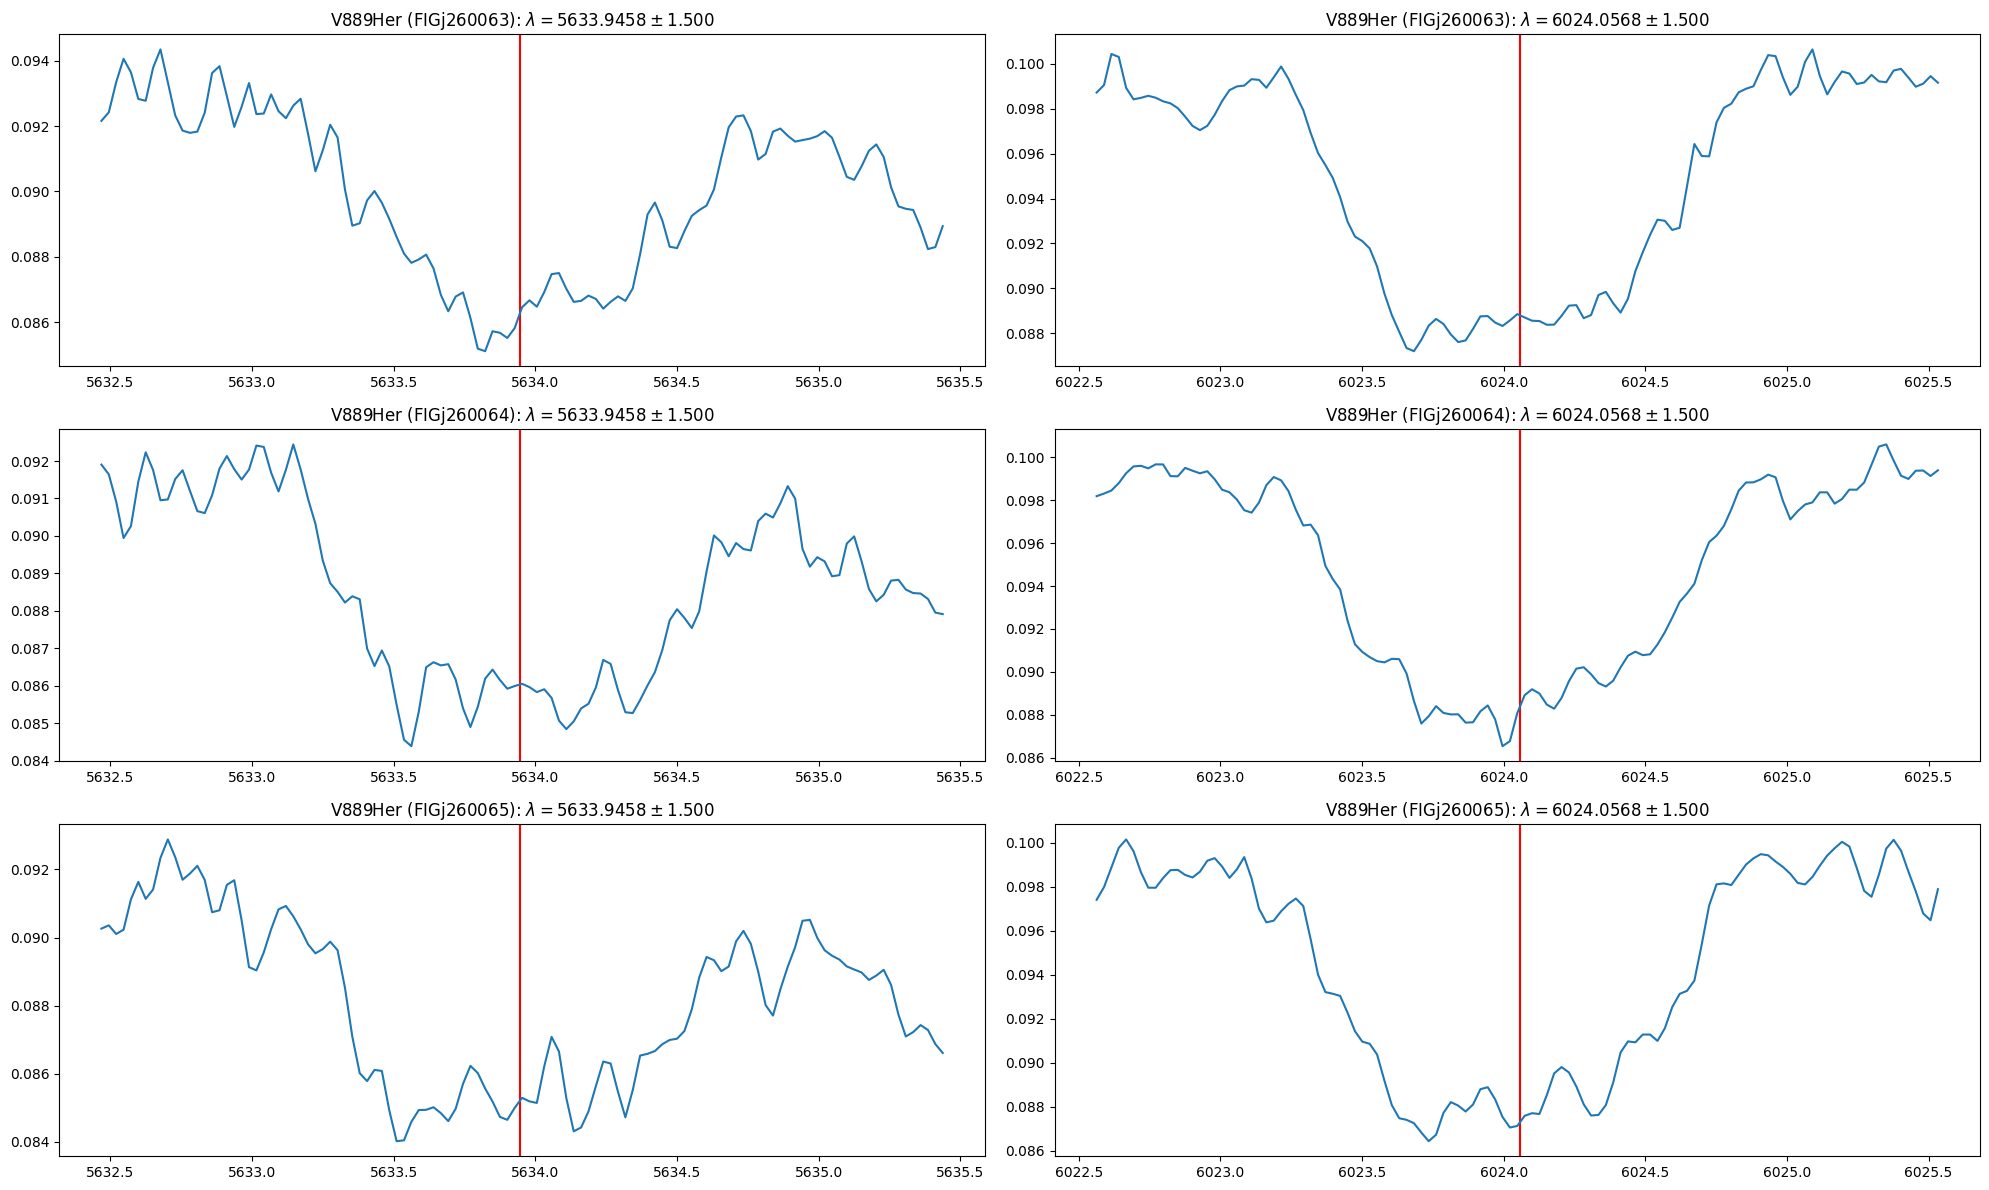

Loading target spectra...
Loaded 3 spectra
Correcting spectra...
Done
** V889Her **
	 - Mean: 1.7430814221377369
	 - Median: 1.618007587013662
	 - Standard Deviation: 0.8860646918526032
	 - [Min, Max]: [0.1437547858376053, 3.029598348228648]
V_rad estimations with FIGj260063: [1.61800759 1.13186905 3.02959835 2.52324358 1.41113808]


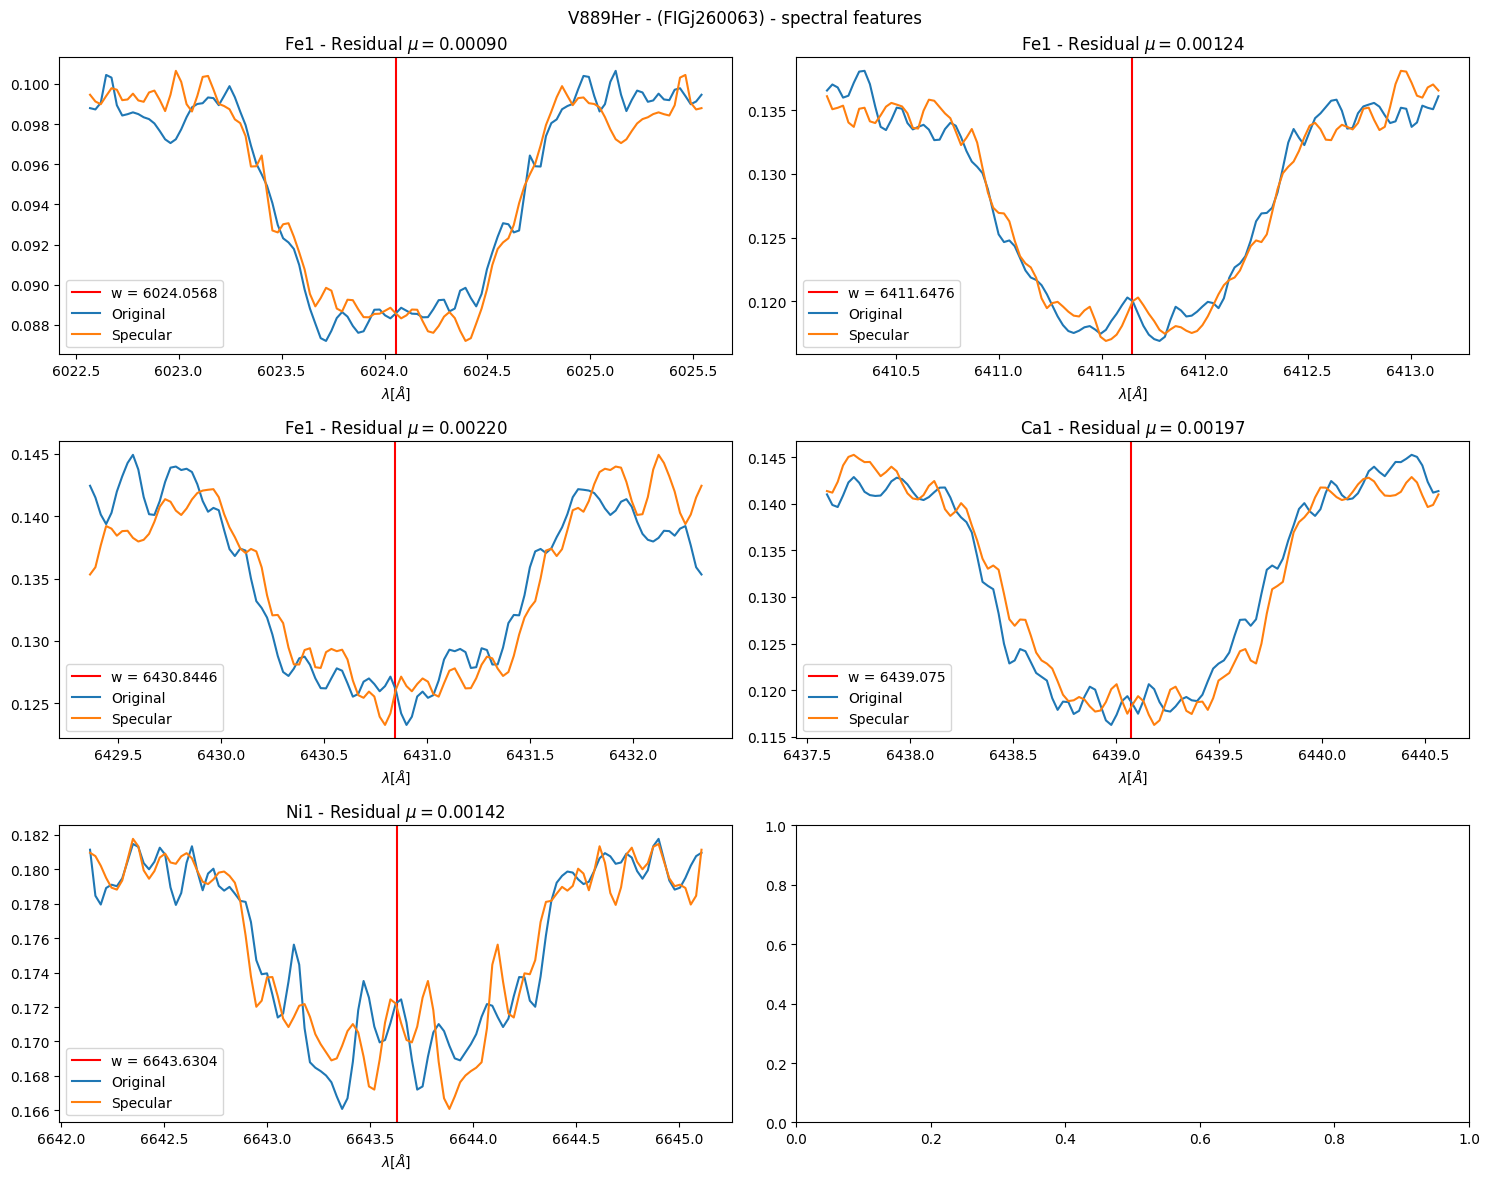

V_rad estimations with FIGj260064: [0.14375479 2.98263312 0.80732669 1.17340393 1.52340817]


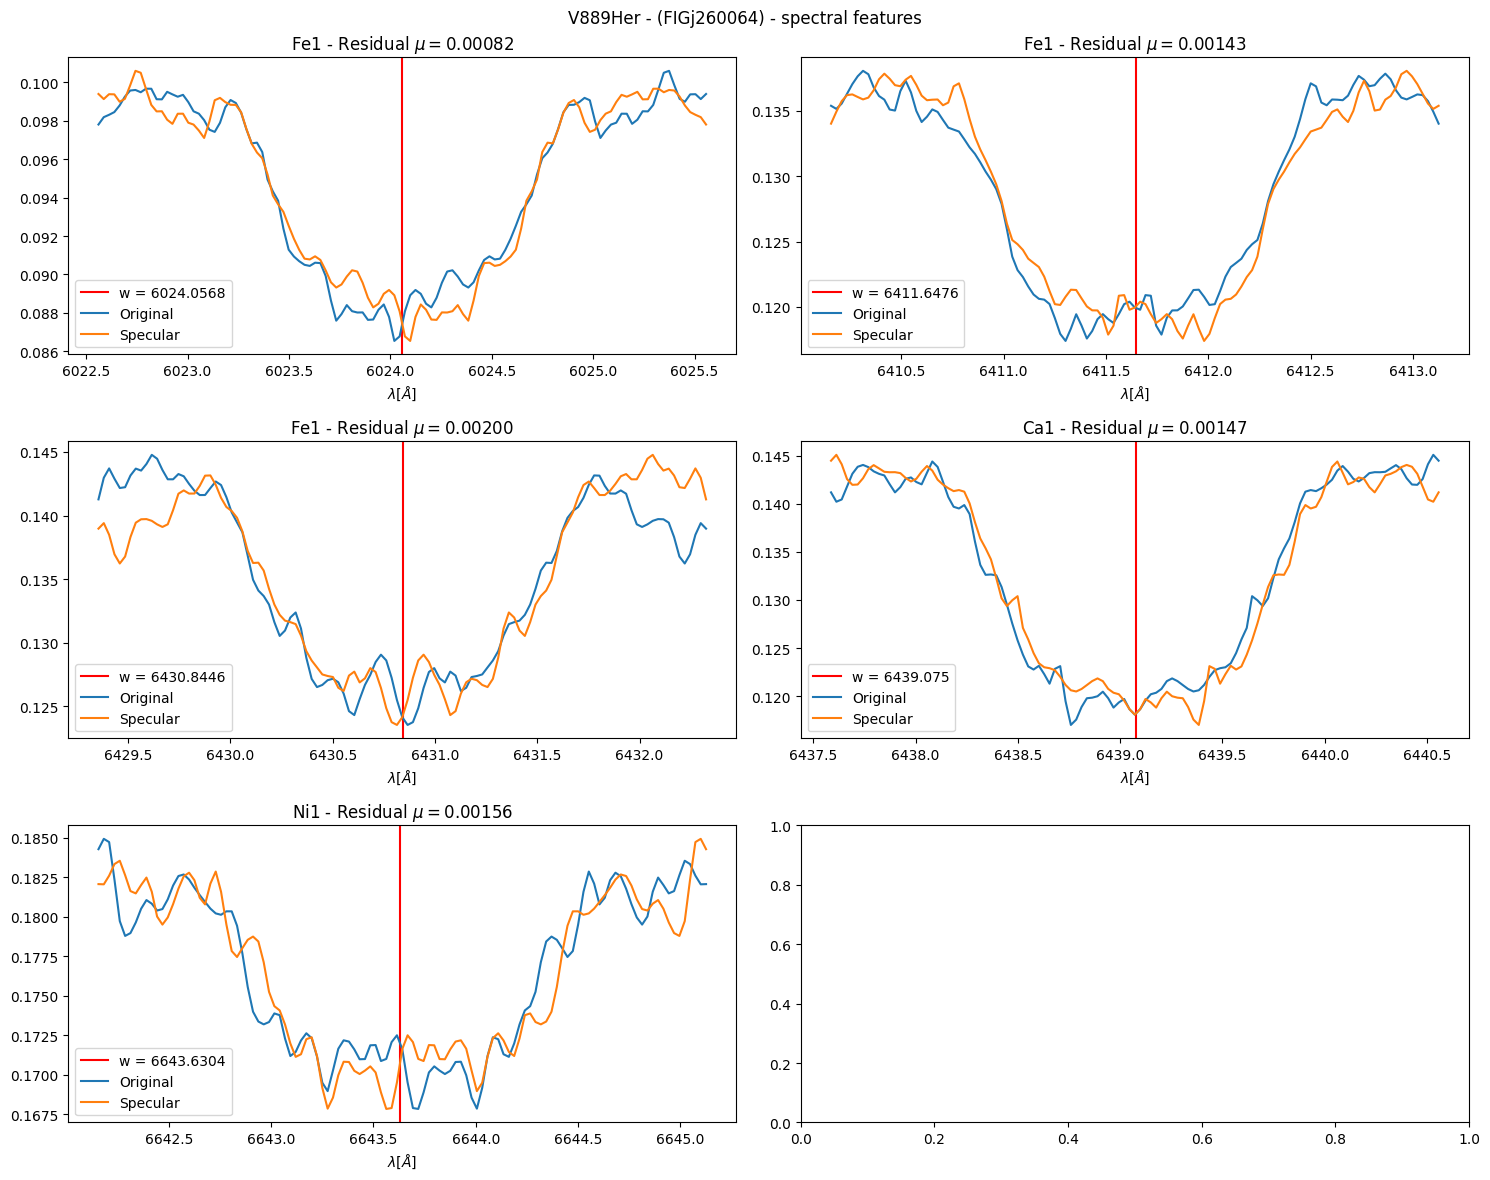

V_rad estimations with FIGj260065: [2.66093919 0.42814256 2.4377297  2.52834205 1.74668448]


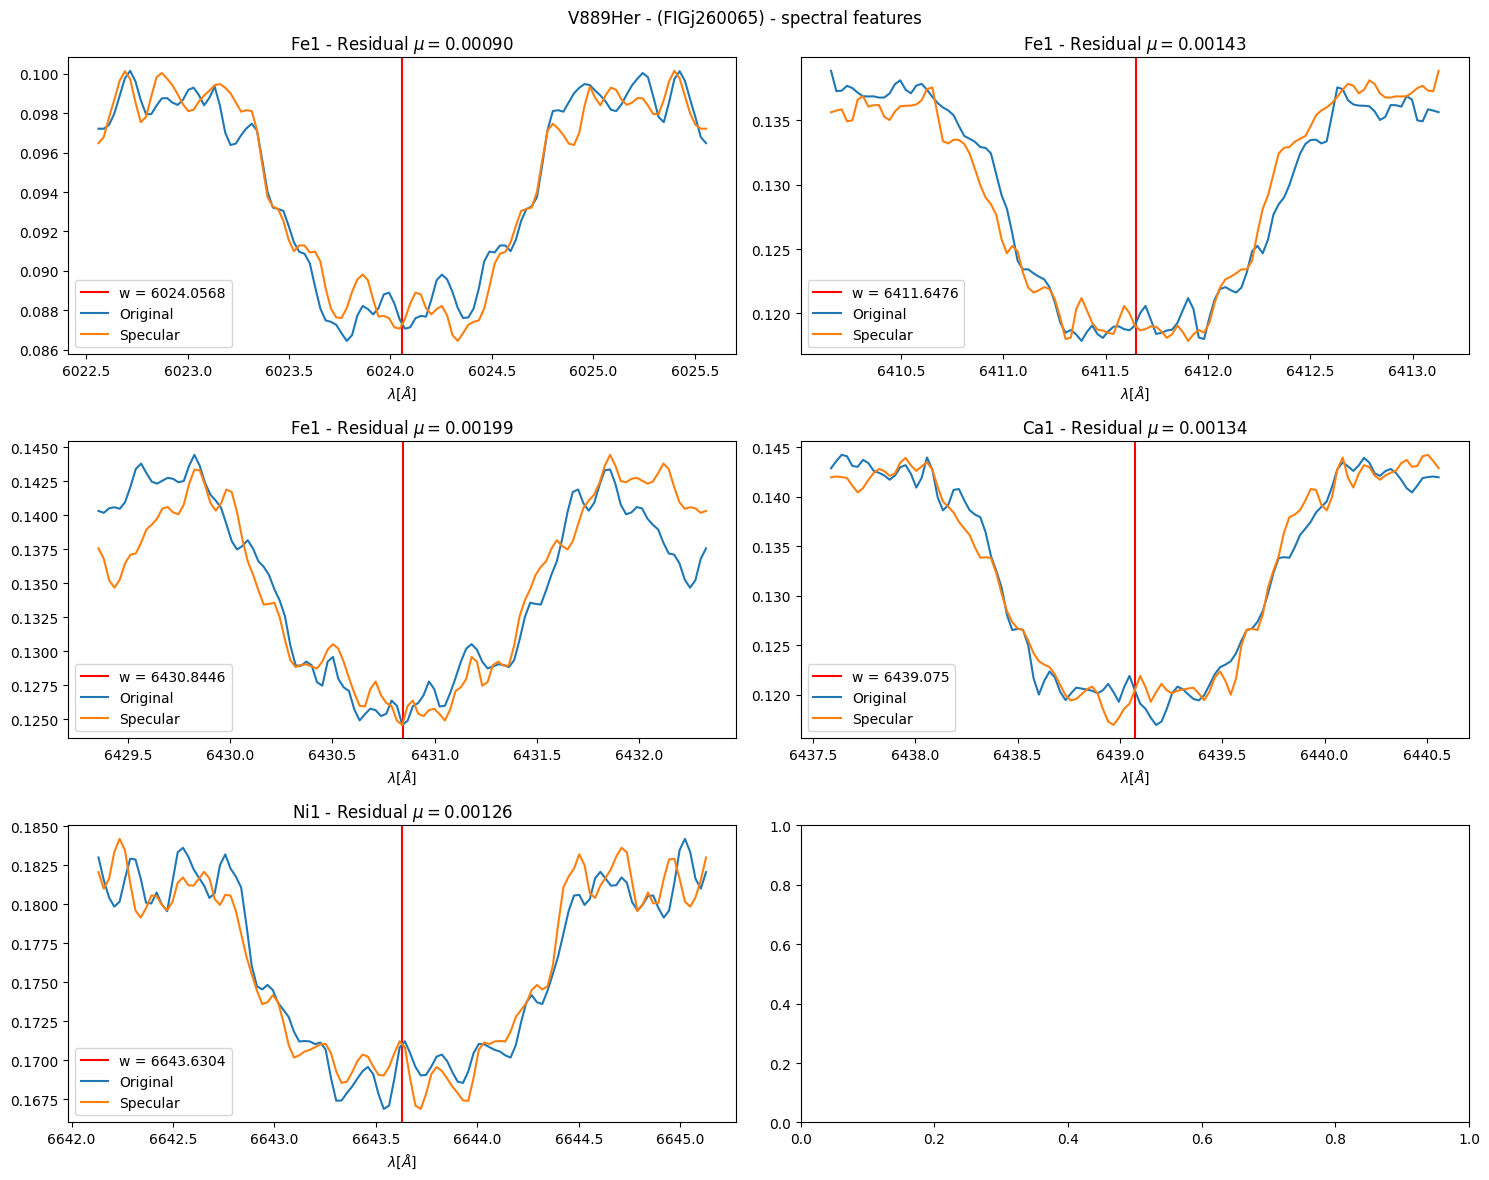

In [10]:
def correct_V889Her():
    target = "V889Her"
    spectra = spectrum_loader.get_spectra(target)
    features = get_spectral_features_vrad_correction()
    
    print(f"{target} v_rad estimations with default features")
    for spectrum in spectra:
        estimations = estimate_v_rad(spectrum.data, features)
        print(f"V_rad estimations with {spectrum.id}: {estimations}")
    
    f1, f2 = features[0], features[1]
    plot_zoom(spectra, [f1.w, f2.w], f1.width)
    
    # Let's try smoothing
    features = features[1:]
    
    estimations = estimate_all_targets_vrad([target], features)
    df = print_estimation_statistics(estimations)
        
    for spectrum in spectra:
        estimations = estimate_v_rad(spectrum.data, features)
        print(f"V_rad estimations with {spectrum.id}: {estimations}")
        
        spectrum.data = correct_spectrum_for_vrad(spectrum.data, np.median(estimations))
        plot_spectral_features(spectrum, features)
    
    # Apply correction
    _vrads[target] = df[target]
        
correct_V889Her()

# Check alignment of spectral features after correction

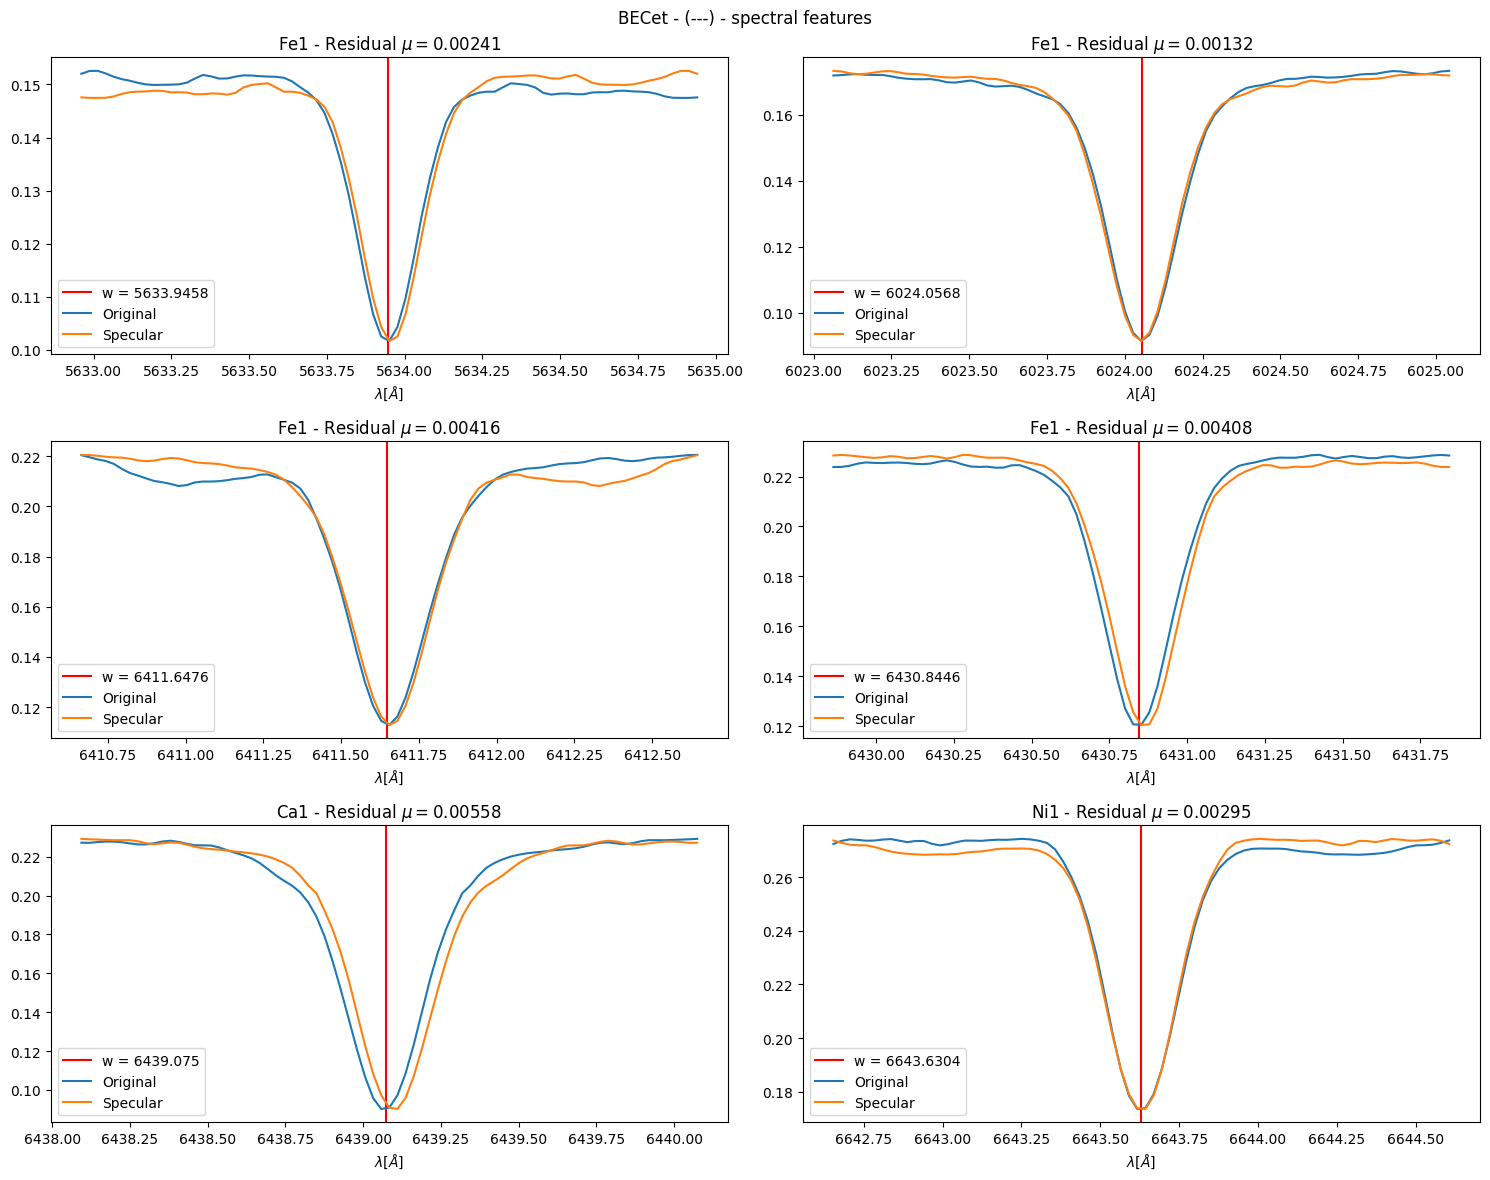

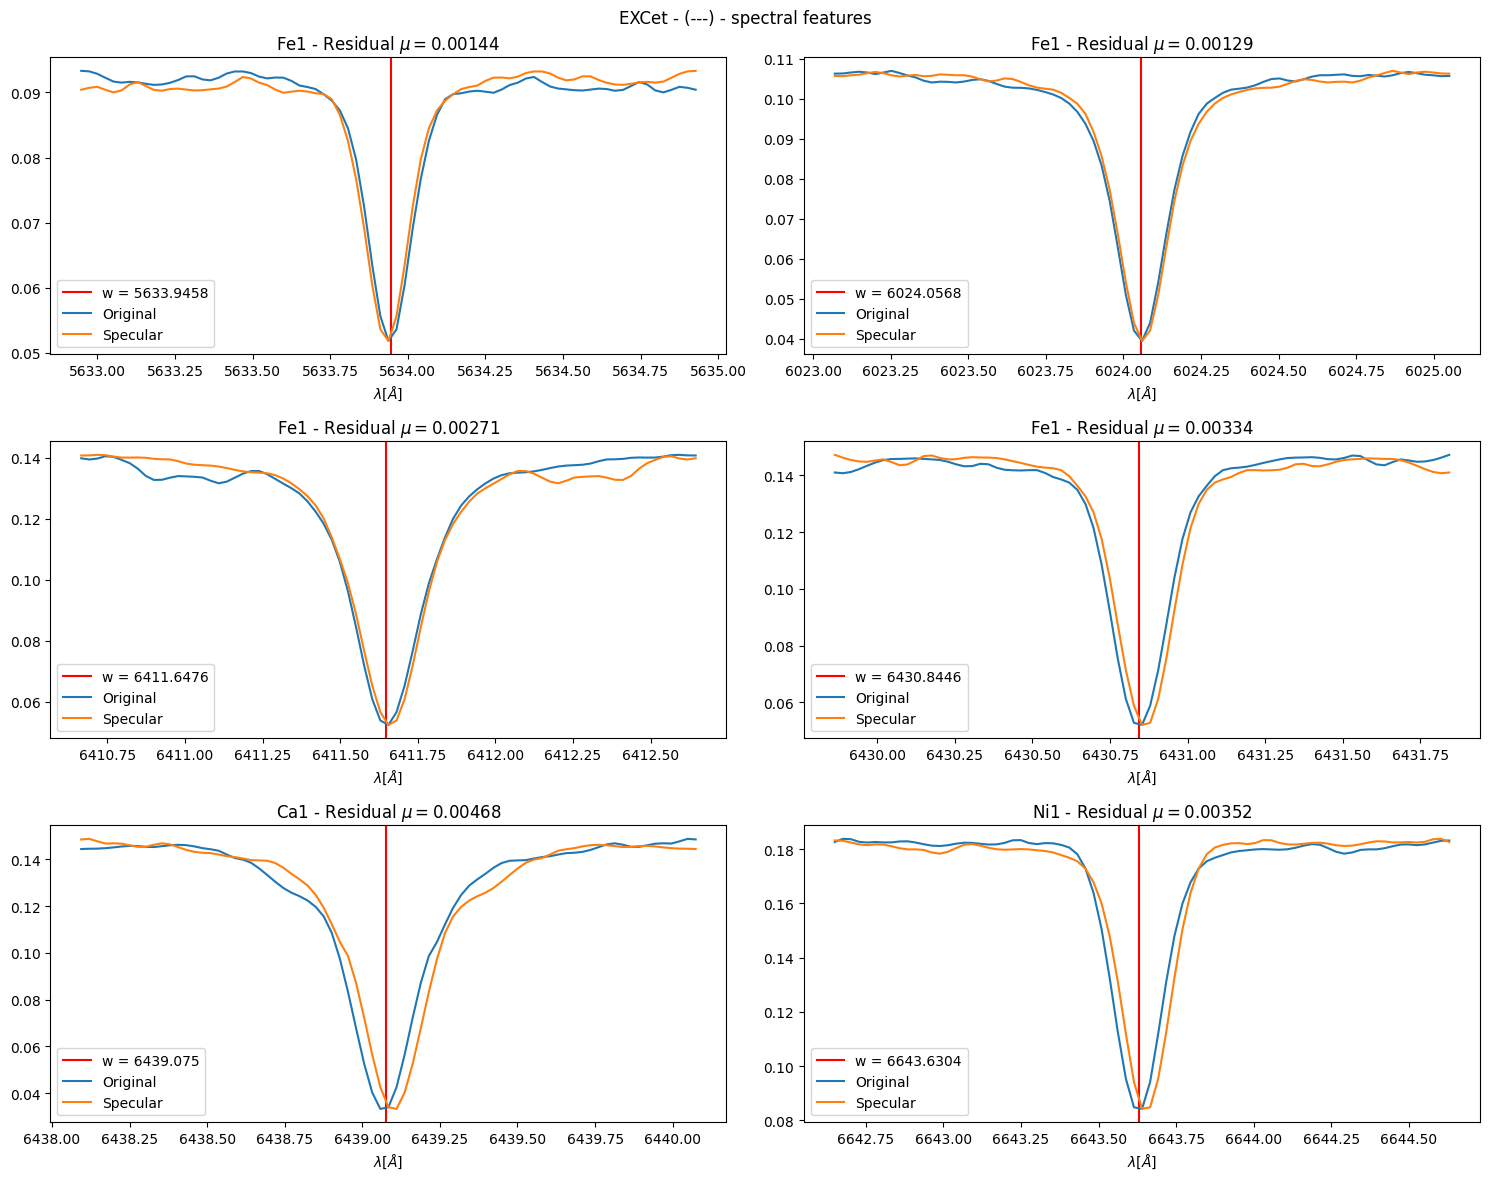

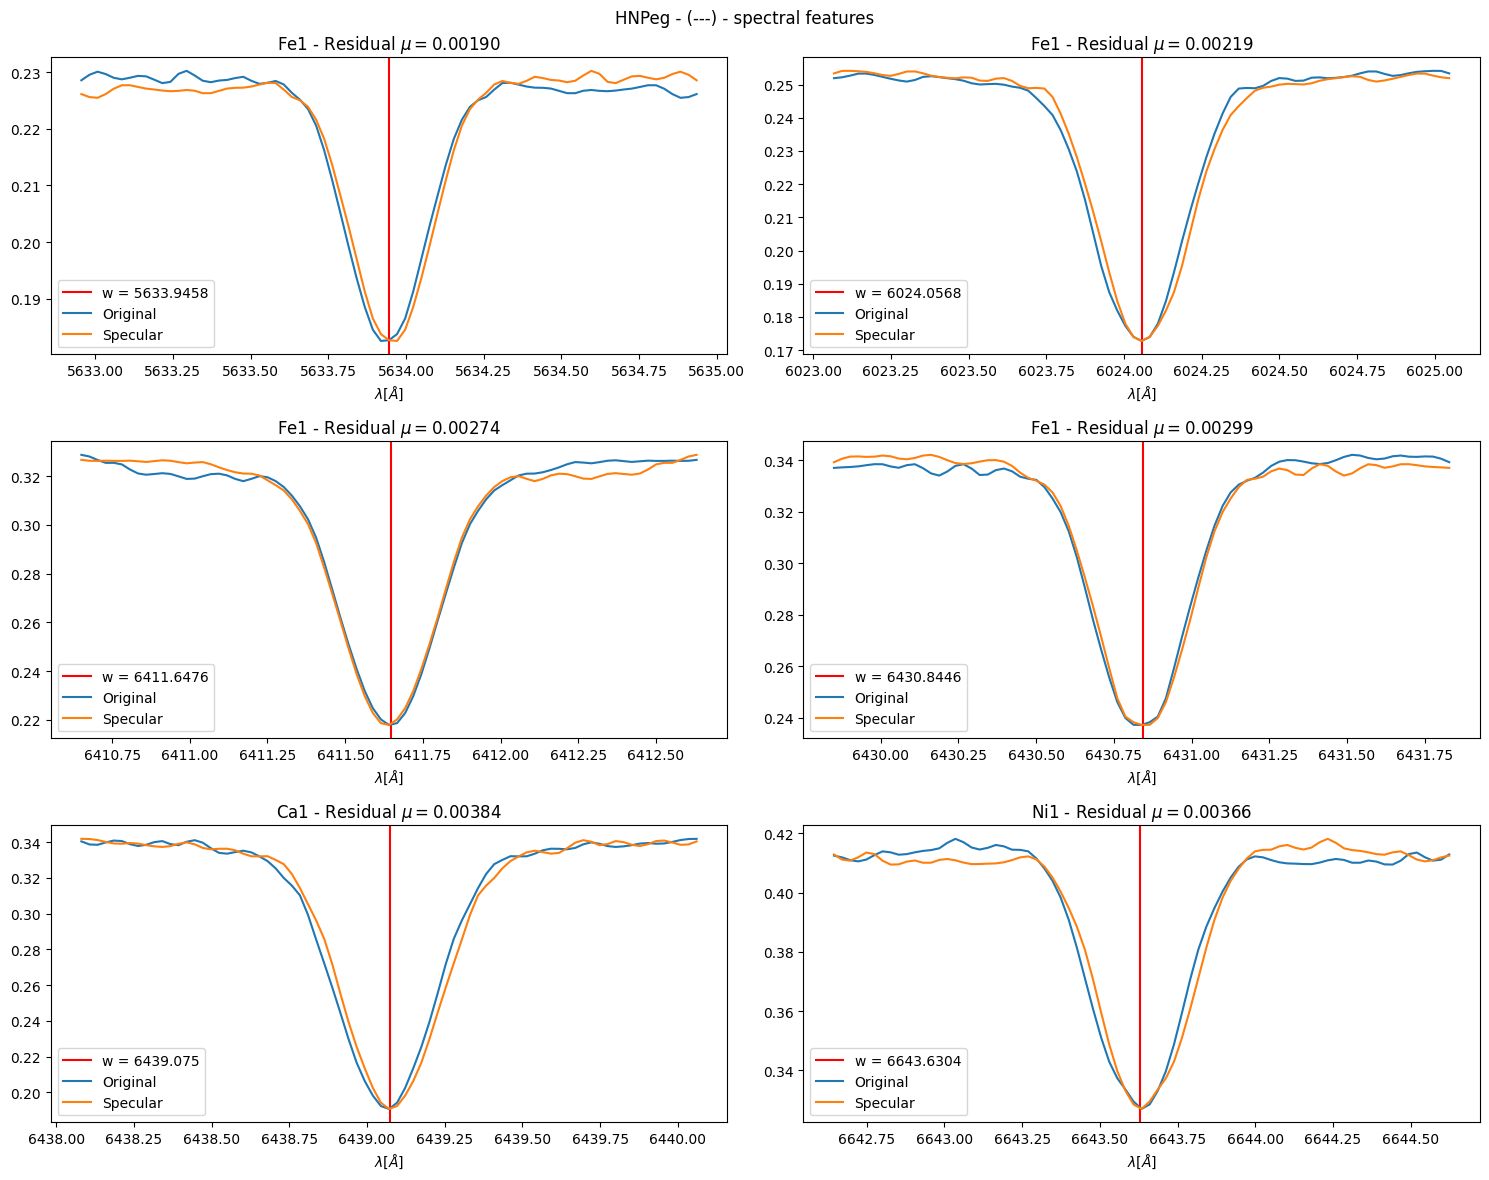

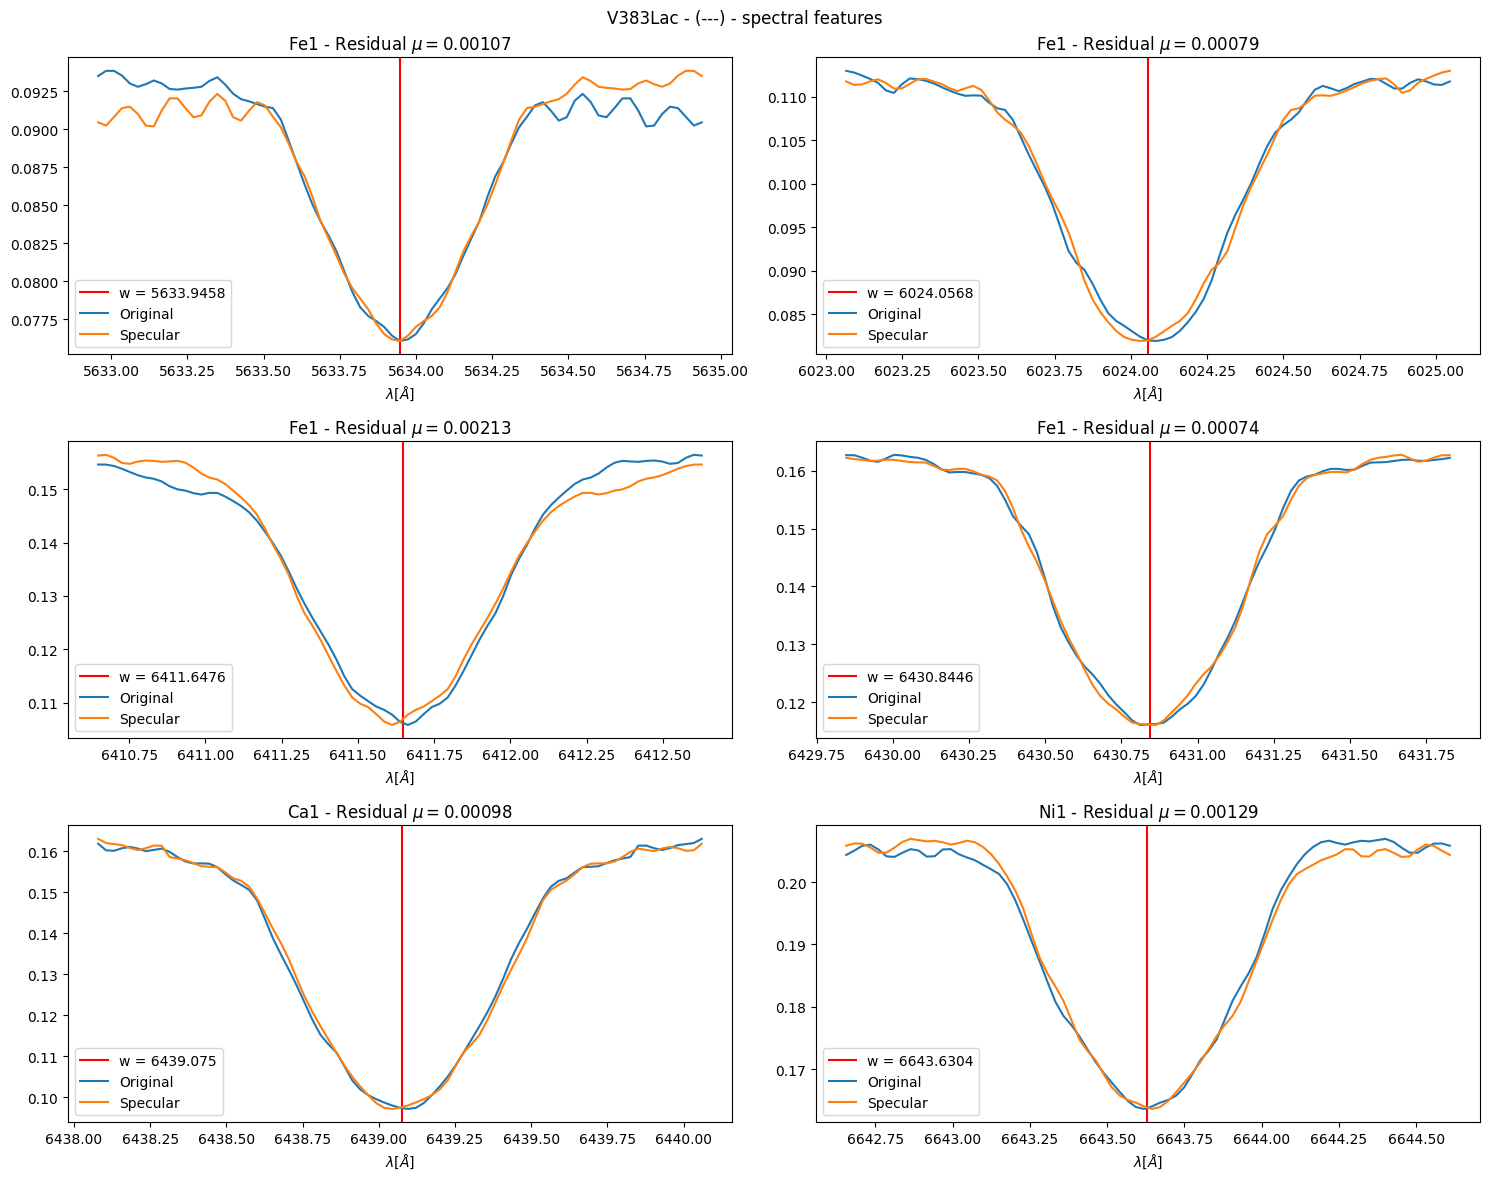

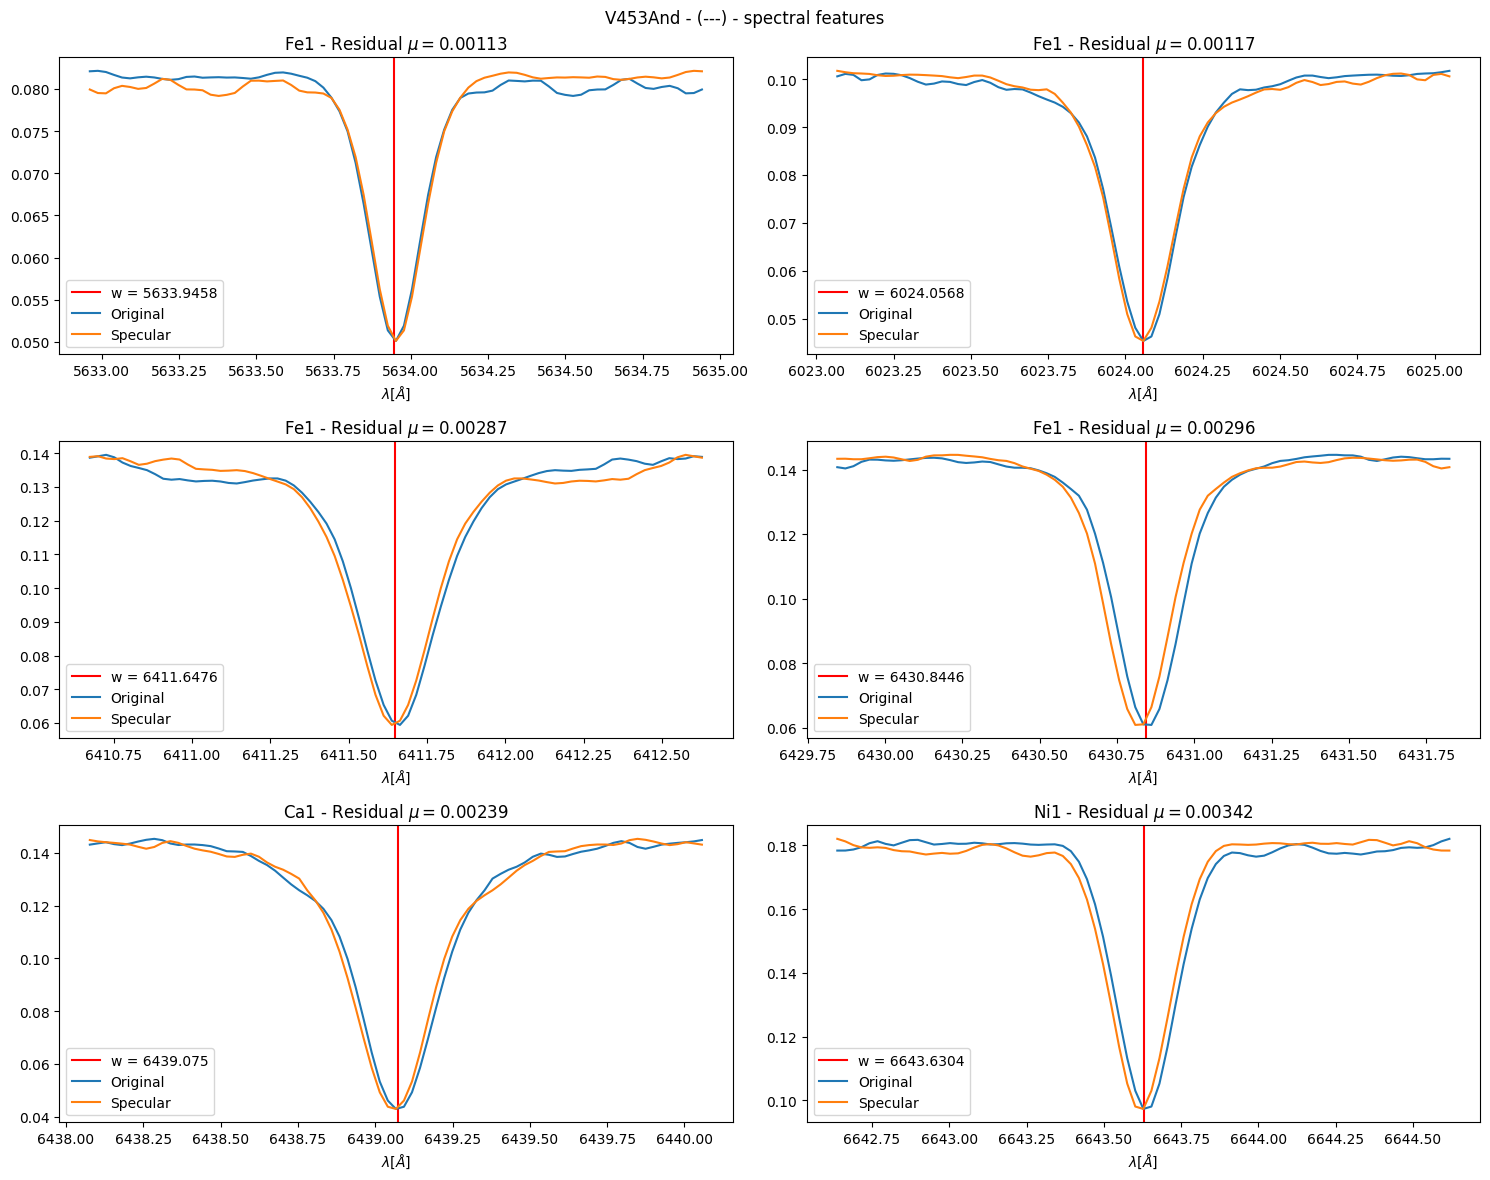

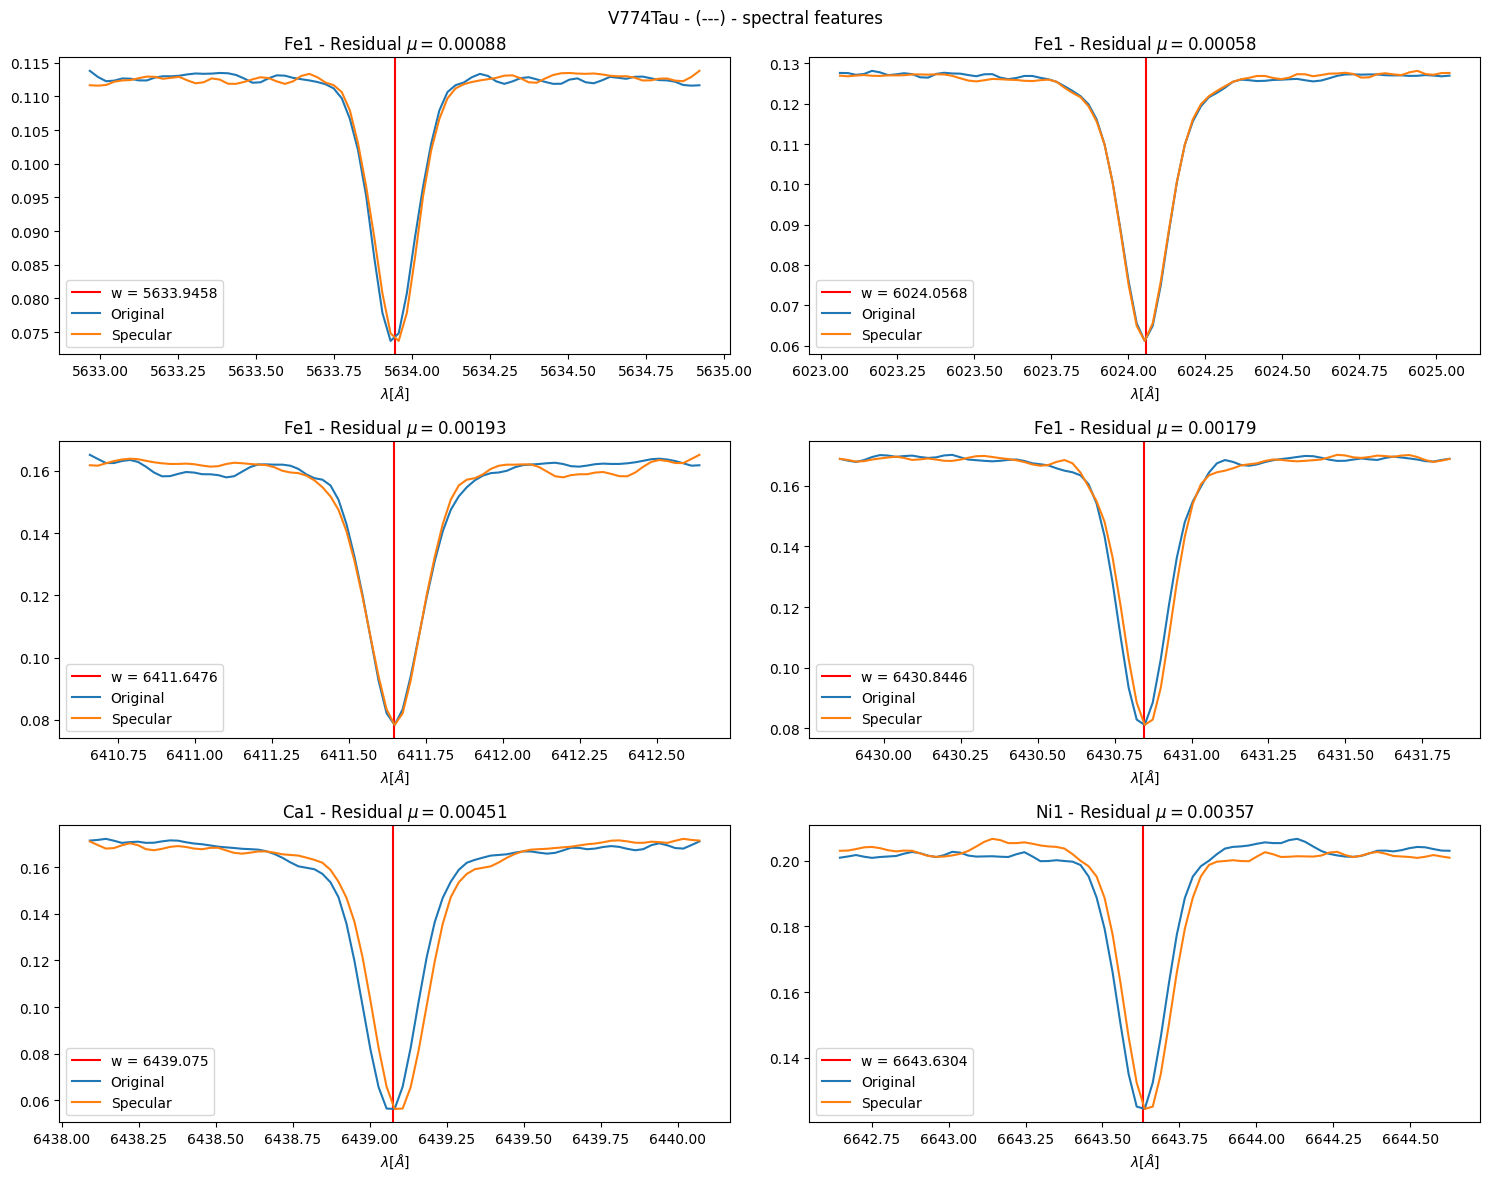

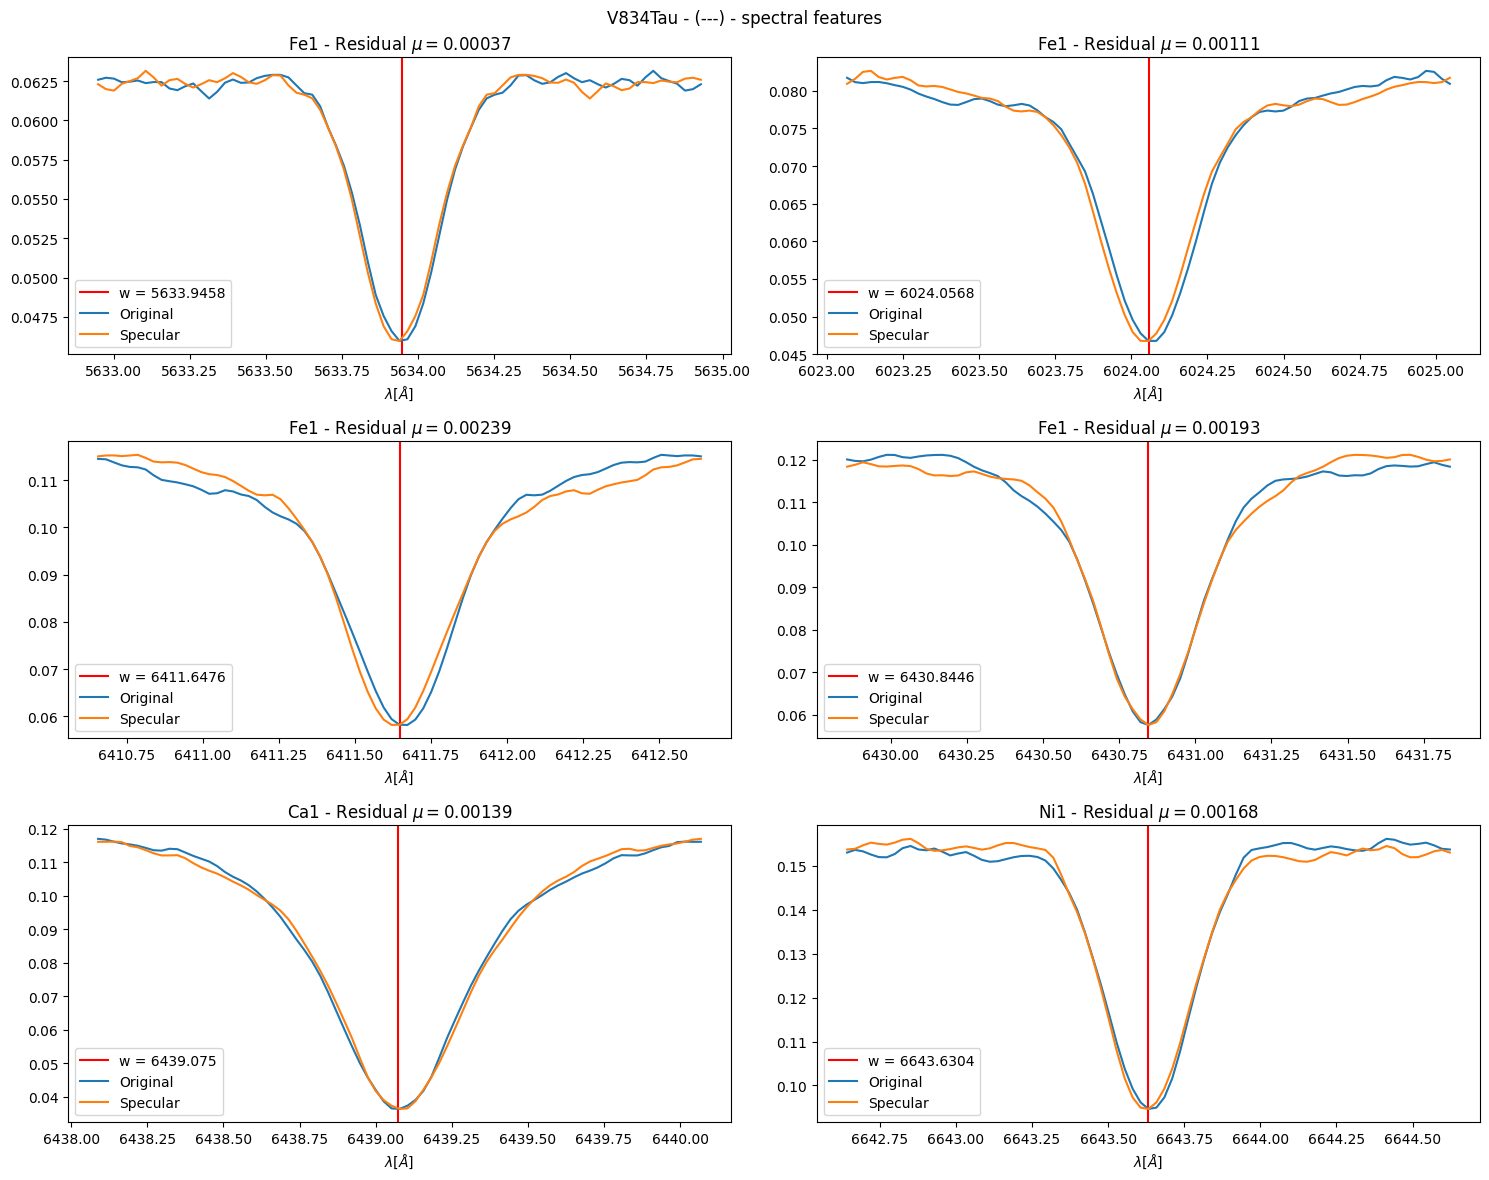

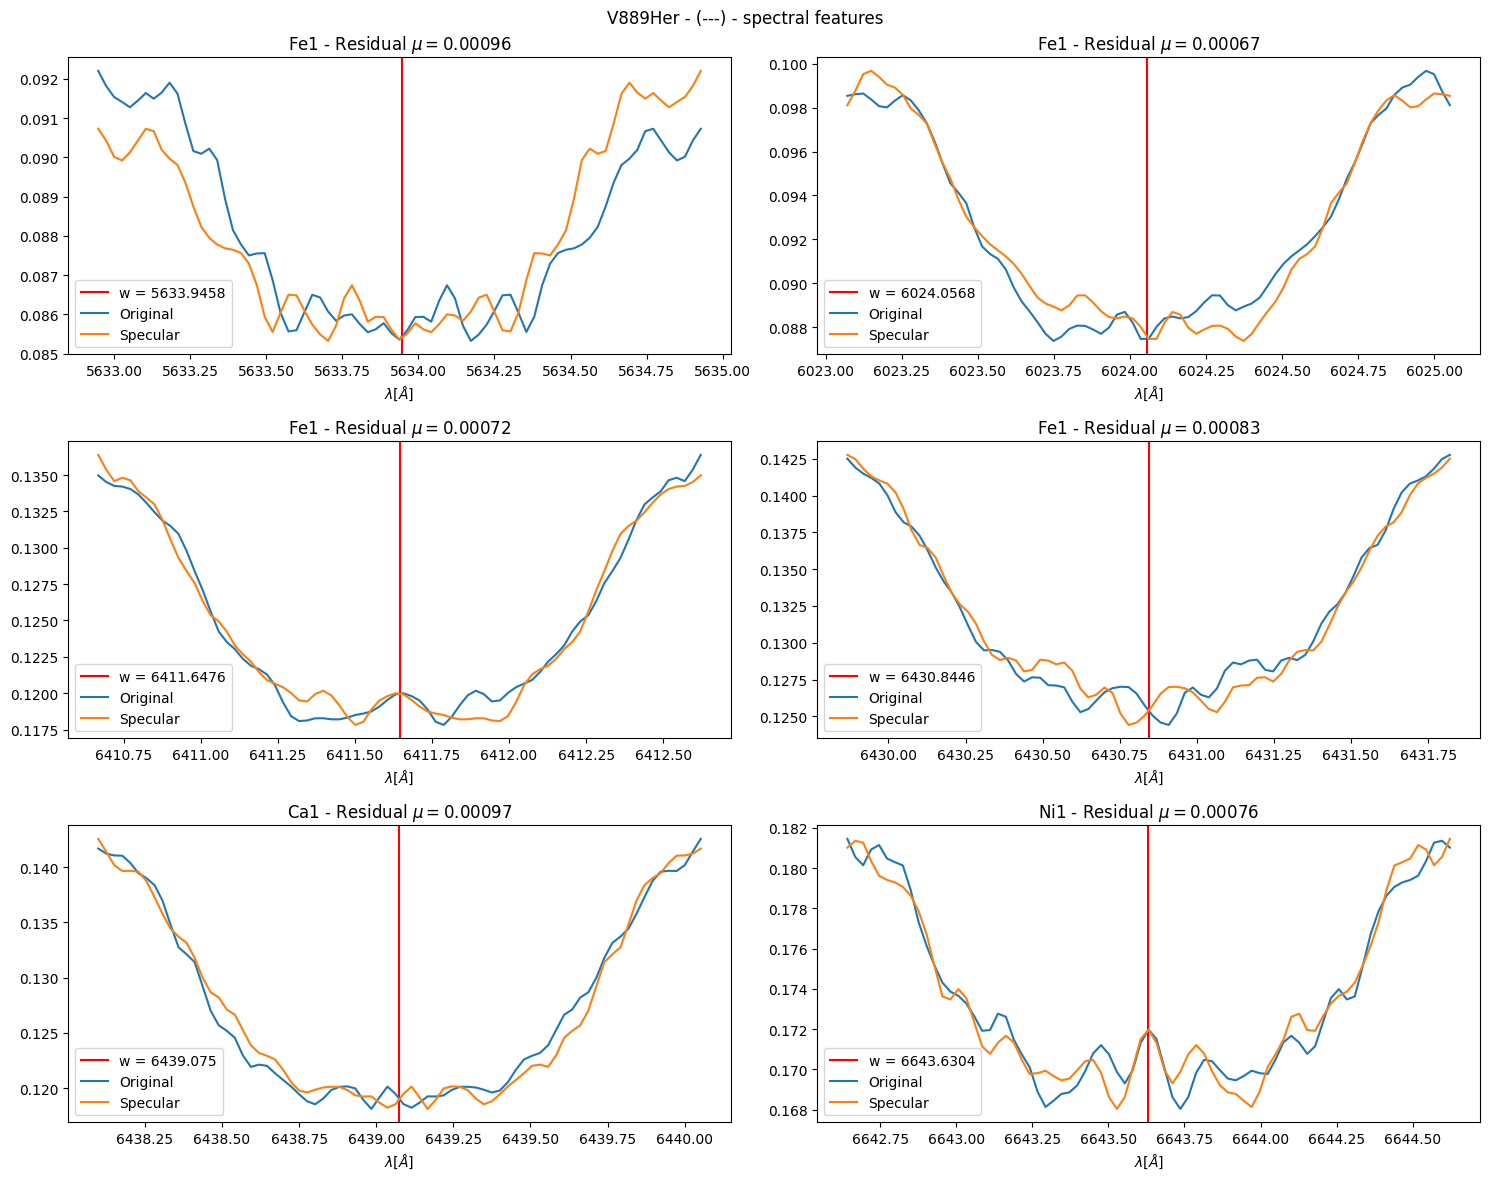

In [11]:
from spectroscopy.spectrum_loader import Spectrum

def plot_all_corrected_spectra():
    for target, data in np.load(CORRECTED_FILE).items():
        spectrum = Spectrum(id="---", target_name=target, data=data)
        plot_spectral_features(spectrum, _spectral_features)

plot_all_corrected_spectra()